In [1]:
from vit_pytorch import ViT
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [2]:

transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)

In [3]:
def fft_transform(data):
    processed_data = []
    for img, _ in data:
        img_np = img.numpy().squeeze()
        fft = np.fft.fft2(img_np)
        processed_data.append((img_np, fft))
    return processed_data

train_fft = fft_transform(train_data)
test_fft = fft_transform(test_data)

def normalize_fft(fft_data):
    normalized_data = []
    for img_np, fft in fft_data:
        # Calculate magnitude and phase
        magnitude = np.abs(fft)
        phase = np.angle(fft)
        
        # Normalize magnitude to [0, 1] range
        magnitude_min = np.min(magnitude)
        magnitude_max = np.max(magnitude)
        normalized_magnitude = (magnitude - magnitude_min) / (magnitude_max - magnitude_min)
        
        # Rebuild complex number using normalized magnitude and original phase
        normalized_fft = normalized_magnitude * np.exp(1j * phase)
        
        normalized_data.append((img_np, normalized_fft))
    
    return normalized_data

# train_fft = normalize_fft(train_fft)
# test_fft = normalize_fft(test_fft)

1.0 0.0 (299.0078472062014+0j) (-105.1554452474781-85.19899857776973j)


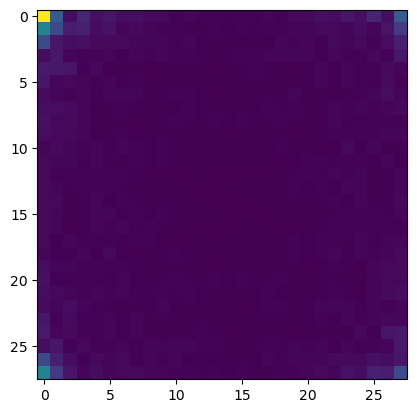

In [4]:
plt.imshow(np.abs(train_fft[0])[1])
print(train_fft[0][0].max(), train_fft[0][0].min(), train_fft[0][1].max(), train_fft[0][1].min())

In [5]:
def phase_shift_fourier(fourier_image, x=2.0, y=2.0):
    """
    Perform a random phase shift on a Fourier-image, constrained by maximum values.
    
    Parameters:
    fourier_image (torch.tensor): Complex-valued centered Fourier representation of an image
    x (float): Maximum amount to shift in x direction (0-2 range recommended due to 2pi periodicity)
    y (float): Maximum amount to shift in y direction (0-2 range recommended due to 2pi periodicity)
    
    Returns:
    torch.tensor: The phase-shifted Fourier-image
    """
    fourier_image = torch.fft.fftshift(fourier_image)
    rows, cols = fourier_image.shape
    
    # Generate random shift amounts within the specified ranges
    random_x = torch.rand(1).item() * x
    random_y = torch.rand(1).item() * y
    shift_x = random_y * torch.pi * rows
    shift_y = random_x * torch.pi * cols
    
    freq_x = torch.fft.fftfreq(cols)
    freq_y = torch.fft.fftfreq(rows)
    fx, fy = torch.meshgrid(freq_x, freq_y, indexing='ij')
    
    # Calculate and apply phase shift
    phase_shift = torch.exp(-1j * (shift_x * fx + shift_y * fy))
    shifted_fourier_image = torch.fft.fftshift(fourier_image * phase_shift)
    
    return shifted_fourier_image


def mask_frequency_spectrum(spectrum, max_mask_percentage):
    # Ensure the max_mask_percentage is between 0 and 100
    max_mask_percentage = torch.clamp(torch.tensor(max_mask_percentage), 0, 100)
    
    # Generate a random mask percentage
    mask_percentage = torch.rand(1) * max_mask_percentage
    
    # Calculate the number of elements to mask
    num_elements = spectrum.numel()
    num_masked = int(num_elements * mask_percentage.item() / 100)
    
    # Create a flat copy of the spectrum
    flat_spectrum = spectrum.view(-1)
    
    # Randomly select indices to mask
    mask_indices = torch.randperm(num_elements)[:num_masked]
    
    # Create a mask tensor
    mask = torch.ones_like(flat_spectrum, dtype=torch.bool)
    mask[mask_indices] = False
    
    # Apply the mask
    masked_spectrum = flat_spectrum.clone()
    masked_spectrum[~mask] = 0
    
    # Reshape the spectrum back to its original shape
    masked_spectrum = masked_spectrum.view(spectrum.shape)
    
    return masked_spectrum

In [6]:
class CustomTransform:
    def __init__(self, is_training=True):
        self.is_training = is_training
        
    def __call__(self, sample):
        img, fft = torch.tensor(np.array(sample))
        if self.is_training: 
            fft = torch.fft.fftshift(fft)
            fft = phase_shift_fourier(fft)
            fft = mask_frequency_spectrum(fft, 75)
            fft = torch.fft.fftshift(fft)
            img = torch.fft.ifft2(fft)
                # Split the complex image into real and imaginary parts
        img_real = torch.real(img)
        img_imag = torch.imag(img)
        
        # Stack the real and imaginary parts of the image
        img_stacked = torch.stack([img_real, img_imag])
        
        return img_stacked.float()

In [7]:
class ComplexDataset(Dataset):
    def __init__(self, data, labels, is_training=True):
        self.data = data
        self.labels = labels
        self.transform = CustomTransform(is_training)
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]
        sample = self.transform(sample)
        return sample, label

In [28]:
# Create the custom dataset
train_labels = [label for _, label in train_data]
train_dataset = ComplexDataset(train_fft, train_labels, is_training=True)

test_labels = [label for _, label in test_data]
test_dataset = ComplexDataset(test_fft, test_labels, is_training=False)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(len(train_loader))

938


In [33]:
item = next(iter(train_loader))

torch.Size([64, 2, 28, 28])


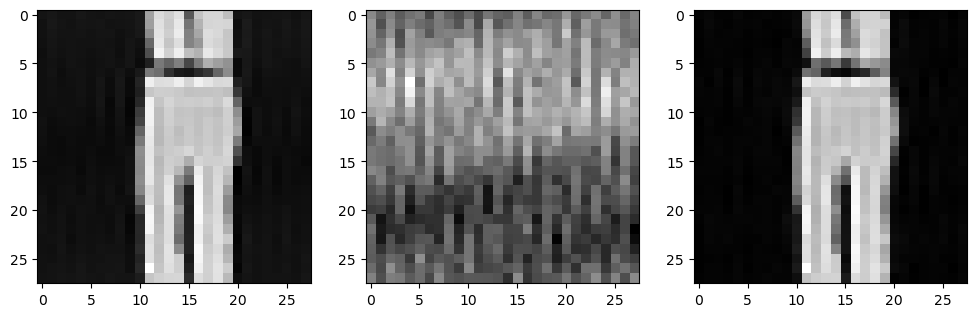

In [35]:
complex = torch.complex(item[0][0,0,:,:],item[0][0,1,:,:])
print(item[0].shape)
plt.figure(figsize=(12,8))
plt.subplot(1,3,1)
plt.imshow(item[0][0,0,:,:], cmap="gray")
plt.subplot(1,3,2)
plt.imshow(item[0][0,1,:,:], cmap="gray")
plt.subplot(1,3,3)
plt.imshow(torch.abs(complex), cmap="gray")


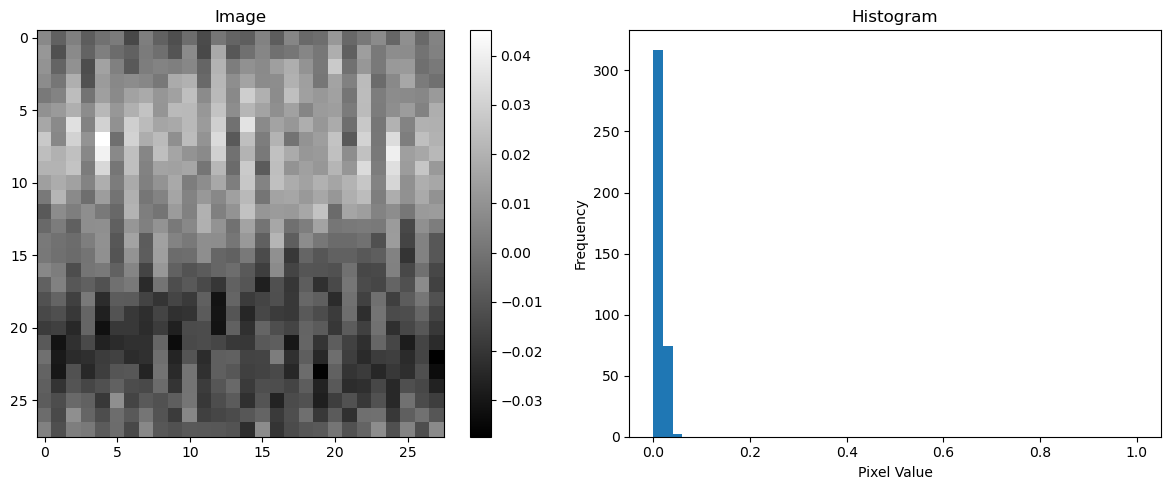

In [36]:

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the image
im = ax1.imshow(item[0][0,1,:,:], cmap="gray")
ax1.set_title("Image")
fig.colorbar(im, ax=ax1)

# Plot the histogram
ax2.hist(item[0][0,1,:,:].ravel(), bins=50, range=(0, 1))
ax2.set_title("Histogram")
ax2.set_xlabel("Pixel Value")
ax2.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [37]:
model = ViT(
    image_size = 28,
    patch_size = 7,
    num_classes = 10,
    dim = 256,
    depth = 6,
    heads = 12,
    mlp_dim = 512,
    dropout = 0.1,
    emb_dropout = 0.1,
    channels = 2
)

img = torch.randn(1, 2, 28, 28)

preds = model(img) # (1, 1000)

In [38]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 6337486


In [39]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [40]:
writer = SummaryWriter('runs/experiment_1') 

def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch")
    for batch_idx, (data, target) in enumerate(progress_bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        progress_bar.set_postfix({"Train Loss": train_loss / (batch_idx + 1), "Train Acc": 100. * correct / total})
        
        # Log batch-level metrics
        writer.add_scalar('Loss/Train Batch', loss.item(), epoch * len(train_loader) + batch_idx)
        writer.add_scalar('Accuracy/Train Batch', 100. * correct / total, epoch * len(train_loader) + batch_idx)
    
    train_loss /= len(train_loader)
    train_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Train Epoch', train_loss, epoch)
    writer.add_scalar('Accuracy/Train Epoch', train_accuracy, epoch)
    
    return train_loss, train_accuracy

def test(model, device, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = 100. * correct / total
    
    # Log epoch-level metrics
    writer.add_scalar('Loss/Test', test_loss, epoch)
    writer.add_scalar('Accuracy/Test', test_accuracy, epoch)
    
    return test_loss, test_accuracy


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [42]:


model.to(device)
epochs = 1000
for epoch in range(581, epochs + 1):
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, criterion, epoch)
    test_loss, test_accuracy = test(model, device, test_loader, criterion, epoch)
    print(f"Epoch {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    print()


writer.close()

Epoch 581: 100%|██████████| 938/938 [00:54<00:00, 17.16batch/s, Train Loss=1.41, Train Acc=46.9]


Epoch 581
Train Loss: 1.4071, Train Accuracy: 46.92%
Test Loss: 1.0339, Test Accuracy: 59.78%



Epoch 582: 100%|██████████| 938/938 [00:55<00:00, 16.80batch/s, Train Loss=1.09, Train Acc=59.1]


Epoch 582
Train Loss: 1.0944, Train Accuracy: 59.10%
Test Loss: 0.9319, Test Accuracy: 65.95%



Epoch 583: 100%|██████████| 938/938 [00:54<00:00, 17.27batch/s, Train Loss=1.01, Train Acc=62.2]


Epoch 583
Train Loss: 1.0096, Train Accuracy: 62.19%
Test Loss: 0.7668, Test Accuracy: 72.30%



Epoch 584: 100%|██████████| 938/938 [00:53<00:00, 17.59batch/s, Train Loss=0.958, Train Acc=64.5]


Epoch 584
Train Loss: 0.9584, Train Accuracy: 64.52%
Test Loss: 0.7879, Test Accuracy: 71.24%



Epoch 585: 100%|██████████| 938/938 [00:53<00:00, 17.60batch/s, Train Loss=0.916, Train Acc=66.4]


Epoch 585
Train Loss: 0.9164, Train Accuracy: 66.41%
Test Loss: 0.7057, Test Accuracy: 74.61%



Epoch 586: 100%|██████████| 938/938 [00:53<00:00, 17.68batch/s, Train Loss=0.883, Train Acc=67.5]


Epoch 586
Train Loss: 0.8833, Train Accuracy: 67.52%
Test Loss: 0.6632, Test Accuracy: 76.47%



Epoch 587: 100%|██████████| 938/938 [00:53<00:00, 17.61batch/s, Train Loss=0.847, Train Acc=69]  


Epoch 587
Train Loss: 0.8473, Train Accuracy: 68.96%
Test Loss: 0.6208, Test Accuracy: 76.99%



Epoch 588: 100%|██████████| 938/938 [00:53<00:00, 17.64batch/s, Train Loss=0.817, Train Acc=70.1]


Epoch 588
Train Loss: 0.8167, Train Accuracy: 70.12%
Test Loss: 0.6004, Test Accuracy: 77.91%



Epoch 589: 100%|██████████| 938/938 [00:53<00:00, 17.67batch/s, Train Loss=0.8, Train Acc=70.7]  


Epoch 589
Train Loss: 0.8003, Train Accuracy: 70.71%
Test Loss: 0.5812, Test Accuracy: 78.56%



Epoch 590: 100%|██████████| 938/938 [00:53<00:00, 17.66batch/s, Train Loss=0.777, Train Acc=71.5]


Epoch 590
Train Loss: 0.7772, Train Accuracy: 71.50%
Test Loss: 0.5559, Test Accuracy: 79.52%



Epoch 591: 100%|██████████| 938/938 [00:53<00:00, 17.67batch/s, Train Loss=0.75, Train Acc=72.4] 


Epoch 591
Train Loss: 0.7505, Train Accuracy: 72.38%
Test Loss: 0.5242, Test Accuracy: 80.75%



Epoch 592: 100%|██████████| 938/938 [00:53<00:00, 17.70batch/s, Train Loss=0.739, Train Acc=72.8]


Epoch 592
Train Loss: 0.7388, Train Accuracy: 72.78%
Test Loss: 0.5310, Test Accuracy: 80.34%



Epoch 593: 100%|██████████| 938/938 [00:53<00:00, 17.68batch/s, Train Loss=0.725, Train Acc=73.2]


Epoch 593
Train Loss: 0.7250, Train Accuracy: 73.20%
Test Loss: 0.5298, Test Accuracy: 80.05%



Epoch 594: 100%|██████████| 938/938 [00:53<00:00, 17.66batch/s, Train Loss=0.708, Train Acc=73.7]


Epoch 594
Train Loss: 0.7082, Train Accuracy: 73.66%
Test Loss: 0.5221, Test Accuracy: 80.47%



Epoch 595: 100%|██████████| 938/938 [00:53<00:00, 17.60batch/s, Train Loss=0.698, Train Acc=74.1]


Epoch 595
Train Loss: 0.6982, Train Accuracy: 74.13%
Test Loss: 0.4973, Test Accuracy: 81.67%



Epoch 596: 100%|██████████| 938/938 [00:52<00:00, 17.74batch/s, Train Loss=0.683, Train Acc=74.9]


Epoch 596
Train Loss: 0.6832, Train Accuracy: 74.90%
Test Loss: 0.5188, Test Accuracy: 80.68%



Epoch 597: 100%|██████████| 938/938 [00:53<00:00, 17.70batch/s, Train Loss=0.675, Train Acc=75]  


Epoch 597
Train Loss: 0.6751, Train Accuracy: 75.05%
Test Loss: 0.4899, Test Accuracy: 82.00%



Epoch 598: 100%|██████████| 938/938 [00:53<00:00, 17.70batch/s, Train Loss=0.664, Train Acc=75.6]


Epoch 598
Train Loss: 0.6635, Train Accuracy: 75.56%
Test Loss: 0.4965, Test Accuracy: 81.56%



Epoch 599: 100%|██████████| 938/938 [00:53<00:00, 17.65batch/s, Train Loss=0.646, Train Acc=76.2]


Epoch 599
Train Loss: 0.6456, Train Accuracy: 76.19%
Test Loss: 0.4620, Test Accuracy: 83.08%



Epoch 600: 100%|██████████| 938/938 [00:53<00:00, 17.63batch/s, Train Loss=0.641, Train Acc=76.4]


Epoch 600
Train Loss: 0.6414, Train Accuracy: 76.43%
Test Loss: 0.4748, Test Accuracy: 82.69%



Epoch 601: 100%|██████████| 938/938 [00:53<00:00, 17.63batch/s, Train Loss=0.636, Train Acc=76.5]


Epoch 601
Train Loss: 0.6355, Train Accuracy: 76.48%
Test Loss: 0.4413, Test Accuracy: 83.66%



Epoch 602: 100%|██████████| 938/938 [00:52<00:00, 17.77batch/s, Train Loss=0.627, Train Acc=76.8]


Epoch 602
Train Loss: 0.6267, Train Accuracy: 76.77%
Test Loss: 0.4530, Test Accuracy: 82.86%



Epoch 603: 100%|██████████| 938/938 [00:52<00:00, 17.71batch/s, Train Loss=0.619, Train Acc=77.1]


Epoch 603
Train Loss: 0.6188, Train Accuracy: 77.09%
Test Loss: 0.4455, Test Accuracy: 83.30%



Epoch 604: 100%|██████████| 938/938 [00:53<00:00, 17.61batch/s, Train Loss=0.615, Train Acc=77.3]


Epoch 604
Train Loss: 0.6154, Train Accuracy: 77.30%
Test Loss: 0.4389, Test Accuracy: 83.91%



Epoch 605: 100%|██████████| 938/938 [00:52<00:00, 17.75batch/s, Train Loss=0.607, Train Acc=77.4]


Epoch 605
Train Loss: 0.6072, Train Accuracy: 77.40%
Test Loss: 0.4391, Test Accuracy: 83.72%



Epoch 606: 100%|██████████| 938/938 [00:52<00:00, 17.71batch/s, Train Loss=0.596, Train Acc=78]  


Epoch 606
Train Loss: 0.5955, Train Accuracy: 77.95%
Test Loss: 0.4465, Test Accuracy: 83.72%



Epoch 607: 100%|██████████| 938/938 [00:52<00:00, 17.80batch/s, Train Loss=0.593, Train Acc=78]  


Epoch 607
Train Loss: 0.5932, Train Accuracy: 78.03%
Test Loss: 0.4372, Test Accuracy: 83.88%



Epoch 608: 100%|██████████| 938/938 [00:52<00:00, 17.77batch/s, Train Loss=0.585, Train Acc=78.1]


Epoch 608
Train Loss: 0.5852, Train Accuracy: 78.13%
Test Loss: 0.4105, Test Accuracy: 84.69%



Epoch 609: 100%|██████████| 938/938 [00:52<00:00, 17.77batch/s, Train Loss=0.579, Train Acc=78.7]


Epoch 609
Train Loss: 0.5788, Train Accuracy: 78.68%
Test Loss: 0.4249, Test Accuracy: 84.43%



Epoch 610: 100%|██████████| 938/938 [00:52<00:00, 17.78batch/s, Train Loss=0.572, Train Acc=78.9]


Epoch 610
Train Loss: 0.5719, Train Accuracy: 78.86%
Test Loss: 0.4255, Test Accuracy: 84.19%



Epoch 611: 100%|██████████| 938/938 [00:53<00:00, 17.63batch/s, Train Loss=0.567, Train Acc=78.9]


Epoch 611
Train Loss: 0.5672, Train Accuracy: 78.92%
Test Loss: 0.4154, Test Accuracy: 84.64%



Epoch 612: 100%|██████████| 938/938 [00:53<00:00, 17.64batch/s, Train Loss=0.564, Train Acc=79]  


Epoch 612
Train Loss: 0.5640, Train Accuracy: 79.02%
Test Loss: 0.3970, Test Accuracy: 85.37%



Epoch 613: 100%|██████████| 938/938 [00:53<00:00, 17.57batch/s, Train Loss=0.557, Train Acc=79.6]


Epoch 613
Train Loss: 0.5568, Train Accuracy: 79.58%
Test Loss: 0.4027, Test Accuracy: 85.08%



Epoch 614: 100%|██████████| 938/938 [00:53<00:00, 17.68batch/s, Train Loss=0.551, Train Acc=79.6]


Epoch 614
Train Loss: 0.5515, Train Accuracy: 79.55%
Test Loss: 0.3902, Test Accuracy: 85.62%



Epoch 615: 100%|██████████| 938/938 [00:53<00:00, 17.62batch/s, Train Loss=0.55, Train Acc=79.6] 


Epoch 615
Train Loss: 0.5496, Train Accuracy: 79.61%
Test Loss: 0.3913, Test Accuracy: 85.37%



Epoch 616: 100%|██████████| 938/938 [00:52<00:00, 17.71batch/s, Train Loss=0.543, Train Acc=79.8]


Epoch 616
Train Loss: 0.5430, Train Accuracy: 79.83%
Test Loss: 0.3977, Test Accuracy: 85.30%



Epoch 617: 100%|██████████| 938/938 [00:53<00:00, 17.67batch/s, Train Loss=0.538, Train Acc=80]  


Epoch 617
Train Loss: 0.5377, Train Accuracy: 79.99%
Test Loss: 0.3876, Test Accuracy: 85.81%



Epoch 618: 100%|██████████| 938/938 [00:53<00:00, 17.55batch/s, Train Loss=0.53, Train Acc=80.3] 


Epoch 618
Train Loss: 0.5299, Train Accuracy: 80.32%
Test Loss: 0.3996, Test Accuracy: 85.28%



Epoch 619: 100%|██████████| 938/938 [00:53<00:00, 17.63batch/s, Train Loss=0.531, Train Acc=80.1]


Epoch 619
Train Loss: 0.5310, Train Accuracy: 80.13%
Test Loss: 0.3948, Test Accuracy: 85.08%



Epoch 620: 100%|██████████| 938/938 [00:53<00:00, 17.60batch/s, Train Loss=0.522, Train Acc=80.6]


Epoch 620
Train Loss: 0.5219, Train Accuracy: 80.62%
Test Loss: 0.3874, Test Accuracy: 85.68%



Epoch 621: 100%|██████████| 938/938 [00:53<00:00, 17.61batch/s, Train Loss=0.523, Train Acc=80.6]


Epoch 621
Train Loss: 0.5229, Train Accuracy: 80.56%
Test Loss: 0.3828, Test Accuracy: 86.03%



Epoch 622: 100%|██████████| 938/938 [00:53<00:00, 17.55batch/s, Train Loss=0.515, Train Acc=80.8]


Epoch 622
Train Loss: 0.5149, Train Accuracy: 80.78%
Test Loss: 0.3658, Test Accuracy: 86.61%



Epoch 623: 100%|██████████| 938/938 [00:53<00:00, 17.48batch/s, Train Loss=0.509, Train Acc=81]  


Epoch 623
Train Loss: 0.5085, Train Accuracy: 81.03%
Test Loss: 0.3762, Test Accuracy: 86.06%



Epoch 624: 100%|██████████| 938/938 [00:53<00:00, 17.59batch/s, Train Loss=0.505, Train Acc=81.2]


Epoch 624
Train Loss: 0.5053, Train Accuracy: 81.17%
Test Loss: 0.3669, Test Accuracy: 86.75%



Epoch 625: 100%|██████████| 938/938 [00:53<00:00, 17.56batch/s, Train Loss=0.502, Train Acc=81.1]


Epoch 625
Train Loss: 0.5025, Train Accuracy: 81.07%
Test Loss: 0.3644, Test Accuracy: 86.48%



Epoch 626: 100%|██████████| 938/938 [00:53<00:00, 17.56batch/s, Train Loss=0.504, Train Acc=81.2]


Epoch 626
Train Loss: 0.5039, Train Accuracy: 81.17%
Test Loss: 0.3670, Test Accuracy: 86.39%



Epoch 627: 100%|██████████| 938/938 [00:53<00:00, 17.55batch/s, Train Loss=0.497, Train Acc=81.6]


Epoch 627
Train Loss: 0.4971, Train Accuracy: 81.58%
Test Loss: 0.3540, Test Accuracy: 86.95%



Epoch 628: 100%|██████████| 938/938 [00:53<00:00, 17.41batch/s, Train Loss=0.494, Train Acc=81.6]


Epoch 628
Train Loss: 0.4944, Train Accuracy: 81.56%
Test Loss: 0.3615, Test Accuracy: 86.88%



Epoch 629: 100%|██████████| 938/938 [00:53<00:00, 17.61batch/s, Train Loss=0.49, Train Acc=81.7] 


Epoch 629
Train Loss: 0.4899, Train Accuracy: 81.72%
Test Loss: 0.3609, Test Accuracy: 86.69%



Epoch 630: 100%|██████████| 938/938 [00:53<00:00, 17.54batch/s, Train Loss=0.489, Train Acc=81.7]


Epoch 630
Train Loss: 0.4891, Train Accuracy: 81.73%
Test Loss: 0.3505, Test Accuracy: 86.98%



Epoch 631: 100%|██████████| 938/938 [00:53<00:00, 17.60batch/s, Train Loss=0.482, Train Acc=82]  


Epoch 631
Train Loss: 0.4824, Train Accuracy: 81.95%
Test Loss: 0.3684, Test Accuracy: 86.36%



Epoch 632: 100%|██████████| 938/938 [00:53<00:00, 17.49batch/s, Train Loss=0.478, Train Acc=82.2]


Epoch 632
Train Loss: 0.4783, Train Accuracy: 82.20%
Test Loss: 0.3569, Test Accuracy: 86.65%



Epoch 633: 100%|██████████| 938/938 [00:53<00:00, 17.48batch/s, Train Loss=0.479, Train Acc=82.1]


Epoch 633
Train Loss: 0.4795, Train Accuracy: 82.11%
Test Loss: 0.3530, Test Accuracy: 87.12%



Epoch 634: 100%|██████████| 938/938 [00:53<00:00, 17.45batch/s, Train Loss=0.47, Train Acc=82.6] 


Epoch 634
Train Loss: 0.4699, Train Accuracy: 82.55%
Test Loss: 0.3594, Test Accuracy: 86.79%



Epoch 635: 100%|██████████| 938/938 [00:53<00:00, 17.53batch/s, Train Loss=0.47, Train Acc=82.5] 


Epoch 635
Train Loss: 0.4699, Train Accuracy: 82.55%
Test Loss: 0.3553, Test Accuracy: 86.73%



Epoch 636: 100%|██████████| 938/938 [00:53<00:00, 17.50batch/s, Train Loss=0.467, Train Acc=82.4]


Epoch 636
Train Loss: 0.4672, Train Accuracy: 82.39%
Test Loss: 0.3590, Test Accuracy: 86.51%



Epoch 637: 100%|██████████| 938/938 [00:53<00:00, 17.59batch/s, Train Loss=0.463, Train Acc=82.6]


Epoch 637
Train Loss: 0.4629, Train Accuracy: 82.61%
Test Loss: 0.3509, Test Accuracy: 87.19%



Epoch 638: 100%|██████████| 938/938 [00:53<00:00, 17.59batch/s, Train Loss=0.462, Train Acc=82.7]


Epoch 638
Train Loss: 0.4616, Train Accuracy: 82.67%
Test Loss: 0.3449, Test Accuracy: 87.41%



Epoch 639: 100%|██████████| 938/938 [00:53<00:00, 17.39batch/s, Train Loss=0.459, Train Acc=82.9]


Epoch 639
Train Loss: 0.4590, Train Accuracy: 82.87%
Test Loss: 0.3472, Test Accuracy: 87.34%



Epoch 640: 100%|██████████| 938/938 [00:53<00:00, 17.56batch/s, Train Loss=0.455, Train Acc=83]  


Epoch 640
Train Loss: 0.4548, Train Accuracy: 82.96%
Test Loss: 0.3579, Test Accuracy: 86.95%



Epoch 641: 100%|██████████| 938/938 [00:53<00:00, 17.54batch/s, Train Loss=0.454, Train Acc=82.9]


Epoch 641
Train Loss: 0.4542, Train Accuracy: 82.91%
Test Loss: 0.3376, Test Accuracy: 87.61%



Epoch 642: 100%|██████████| 938/938 [00:53<00:00, 17.57batch/s, Train Loss=0.451, Train Acc=83]  


Epoch 642
Train Loss: 0.4512, Train Accuracy: 83.03%
Test Loss: 0.3386, Test Accuracy: 87.62%



Epoch 643: 100%|██████████| 938/938 [00:53<00:00, 17.56batch/s, Train Loss=0.446, Train Acc=83.3]


Epoch 643
Train Loss: 0.4462, Train Accuracy: 83.31%
Test Loss: 0.3380, Test Accuracy: 87.59%



Epoch 644: 100%|██████████| 938/938 [00:53<00:00, 17.57batch/s, Train Loss=0.449, Train Acc=83.3]


Epoch 644
Train Loss: 0.4491, Train Accuracy: 83.31%
Test Loss: 0.3292, Test Accuracy: 88.16%



Epoch 645: 100%|██████████| 938/938 [00:53<00:00, 17.55batch/s, Train Loss=0.445, Train Acc=83.4]


Epoch 645
Train Loss: 0.4446, Train Accuracy: 83.38%
Test Loss: 0.3323, Test Accuracy: 87.93%



Epoch 646: 100%|██████████| 938/938 [00:53<00:00, 17.41batch/s, Train Loss=0.441, Train Acc=83.4]


Epoch 646
Train Loss: 0.4407, Train Accuracy: 83.45%
Test Loss: 0.3300, Test Accuracy: 87.74%



Epoch 647: 100%|██████████| 938/938 [00:53<00:00, 17.61batch/s, Train Loss=0.439, Train Acc=83.5]


Epoch 647
Train Loss: 0.4387, Train Accuracy: 83.53%
Test Loss: 0.3300, Test Accuracy: 87.72%



Epoch 648: 100%|██████████| 938/938 [00:53<00:00, 17.44batch/s, Train Loss=0.437, Train Acc=83.5]


Epoch 648
Train Loss: 0.4370, Train Accuracy: 83.54%
Test Loss: 0.3214, Test Accuracy: 88.12%



Epoch 649: 100%|██████████| 938/938 [00:53<00:00, 17.48batch/s, Train Loss=0.434, Train Acc=83.7]


Epoch 649
Train Loss: 0.4338, Train Accuracy: 83.71%
Test Loss: 0.3243, Test Accuracy: 87.98%



Epoch 650: 100%|██████████| 938/938 [00:53<00:00, 17.54batch/s, Train Loss=0.431, Train Acc=84]  


Epoch 650
Train Loss: 0.4305, Train Accuracy: 84.04%
Test Loss: 0.3296, Test Accuracy: 87.64%



Epoch 651: 100%|██████████| 938/938 [00:53<00:00, 17.54batch/s, Train Loss=0.431, Train Acc=83.8]


Epoch 651
Train Loss: 0.4309, Train Accuracy: 83.82%
Test Loss: 0.3215, Test Accuracy: 88.51%



Epoch 652: 100%|██████████| 938/938 [00:53<00:00, 17.52batch/s, Train Loss=0.428, Train Acc=84]  


Epoch 652
Train Loss: 0.4280, Train Accuracy: 84.00%
Test Loss: 0.3206, Test Accuracy: 88.40%



Epoch 653: 100%|██████████| 938/938 [00:53<00:00, 17.45batch/s, Train Loss=0.425, Train Acc=84.1]


Epoch 653
Train Loss: 0.4253, Train Accuracy: 84.12%
Test Loss: 0.3247, Test Accuracy: 88.26%



Epoch 654: 100%|██████████| 938/938 [00:53<00:00, 17.58batch/s, Train Loss=0.425, Train Acc=84]  


Epoch 654
Train Loss: 0.4251, Train Accuracy: 84.01%
Test Loss: 0.3204, Test Accuracy: 88.17%



Epoch 655: 100%|██████████| 938/938 [00:53<00:00, 17.51batch/s, Train Loss=0.418, Train Acc=84.3]


Epoch 655
Train Loss: 0.4178, Train Accuracy: 84.30%
Test Loss: 0.3200, Test Accuracy: 88.05%



Epoch 656: 100%|██████████| 938/938 [00:53<00:00, 17.63batch/s, Train Loss=0.418, Train Acc=84.3]


Epoch 656
Train Loss: 0.4176, Train Accuracy: 84.31%
Test Loss: 0.3155, Test Accuracy: 88.48%



Epoch 657: 100%|██████████| 938/938 [00:53<00:00, 17.62batch/s, Train Loss=0.419, Train Acc=84.3]


Epoch 657
Train Loss: 0.4186, Train Accuracy: 84.33%
Test Loss: 0.3158, Test Accuracy: 88.46%



Epoch 658: 100%|██████████| 938/938 [00:53<00:00, 17.61batch/s, Train Loss=0.419, Train Acc=84.2]


Epoch 658
Train Loss: 0.4189, Train Accuracy: 84.22%
Test Loss: 0.3179, Test Accuracy: 88.14%



Epoch 659: 100%|██████████| 938/938 [00:53<00:00, 17.59batch/s, Train Loss=0.413, Train Acc=84.5]


Epoch 659
Train Loss: 0.4128, Train Accuracy: 84.47%
Test Loss: 0.3185, Test Accuracy: 88.55%



Epoch 660: 100%|██████████| 938/938 [00:53<00:00, 17.55batch/s, Train Loss=0.412, Train Acc=84.7]


Epoch 660
Train Loss: 0.4123, Train Accuracy: 84.65%
Test Loss: 0.3224, Test Accuracy: 88.00%



Epoch 661: 100%|██████████| 938/938 [00:53<00:00, 17.61batch/s, Train Loss=0.41, Train Acc=84.6] 


Epoch 661
Train Loss: 0.4099, Train Accuracy: 84.65%
Test Loss: 0.3162, Test Accuracy: 88.27%



Epoch 662: 100%|██████████| 938/938 [00:53<00:00, 17.53batch/s, Train Loss=0.411, Train Acc=84.6]


Epoch 662
Train Loss: 0.4109, Train Accuracy: 84.56%
Test Loss: 0.3243, Test Accuracy: 87.67%



Epoch 663: 100%|██████████| 938/938 [00:53<00:00, 17.50batch/s, Train Loss=0.405, Train Acc=84.9]


Epoch 663
Train Loss: 0.4053, Train Accuracy: 84.89%
Test Loss: 0.3145, Test Accuracy: 88.36%



Epoch 664: 100%|██████████| 938/938 [00:53<00:00, 17.62batch/s, Train Loss=0.405, Train Acc=84.7]


Epoch 664
Train Loss: 0.4052, Train Accuracy: 84.66%
Test Loss: 0.3131, Test Accuracy: 88.56%



Epoch 665: 100%|██████████| 938/938 [00:53<00:00, 17.45batch/s, Train Loss=0.4, Train Acc=85]    


Epoch 665
Train Loss: 0.4003, Train Accuracy: 85.03%
Test Loss: 0.3066, Test Accuracy: 88.83%



Epoch 666: 100%|██████████| 938/938 [00:53<00:00, 17.45batch/s, Train Loss=0.402, Train Acc=84.9]


Epoch 666
Train Loss: 0.4021, Train Accuracy: 84.93%
Test Loss: 0.3120, Test Accuracy: 88.68%



Epoch 667: 100%|██████████| 938/938 [00:53<00:00, 17.52batch/s, Train Loss=0.399, Train Acc=85]  


Epoch 667
Train Loss: 0.3990, Train Accuracy: 85.02%
Test Loss: 0.3041, Test Accuracy: 88.95%



Epoch 668: 100%|██████████| 938/938 [00:53<00:00, 17.45batch/s, Train Loss=0.393, Train Acc=85.2]


Epoch 668
Train Loss: 0.3934, Train Accuracy: 85.23%
Test Loss: 0.3059, Test Accuracy: 88.72%



Epoch 669: 100%|██████████| 938/938 [00:53<00:00, 17.55batch/s, Train Loss=0.396, Train Acc=85.2]


Epoch 669
Train Loss: 0.3961, Train Accuracy: 85.16%
Test Loss: 0.3222, Test Accuracy: 88.09%



Epoch 670: 100%|██████████| 938/938 [00:53<00:00, 17.57batch/s, Train Loss=0.393, Train Acc=85.2]


Epoch 670
Train Loss: 0.3935, Train Accuracy: 85.23%
Test Loss: 0.3297, Test Accuracy: 87.74%



Epoch 671: 100%|██████████| 938/938 [00:53<00:00, 17.56batch/s, Train Loss=0.394, Train Acc=85.2]


Epoch 671
Train Loss: 0.3940, Train Accuracy: 85.23%
Test Loss: 0.3016, Test Accuracy: 88.96%



Epoch 672: 100%|██████████| 938/938 [00:53<00:00, 17.58batch/s, Train Loss=0.392, Train Acc=85.3]


Epoch 672
Train Loss: 0.3920, Train Accuracy: 85.30%
Test Loss: 0.3026, Test Accuracy: 88.97%



Epoch 673: 100%|██████████| 938/938 [00:54<00:00, 17.30batch/s, Train Loss=0.391, Train Acc=85.3]


Epoch 673
Train Loss: 0.3912, Train Accuracy: 85.32%
Test Loss: 0.3145, Test Accuracy: 88.07%



Epoch 674: 100%|██████████| 938/938 [00:56<00:00, 16.67batch/s, Train Loss=0.391, Train Acc=85.3]


Epoch 674
Train Loss: 0.3906, Train Accuracy: 85.29%
Test Loss: 0.3117, Test Accuracy: 88.70%



Epoch 675: 100%|██████████| 938/938 [00:55<00:00, 16.77batch/s, Train Loss=0.385, Train Acc=85.5]


Epoch 675
Train Loss: 0.3848, Train Accuracy: 85.49%
Test Loss: 0.3068, Test Accuracy: 88.70%



Epoch 676: 100%|██████████| 938/938 [00:55<00:00, 17.02batch/s, Train Loss=0.386, Train Acc=85.5]


Epoch 676
Train Loss: 0.3863, Train Accuracy: 85.53%
Test Loss: 0.2995, Test Accuracy: 89.02%



Epoch 677: 100%|██████████| 938/938 [00:54<00:00, 17.37batch/s, Train Loss=0.383, Train Acc=85.5]


Epoch 677
Train Loss: 0.3828, Train Accuracy: 85.54%
Test Loss: 0.3018, Test Accuracy: 89.22%



Epoch 678: 100%|██████████| 938/938 [00:53<00:00, 17.48batch/s, Train Loss=0.379, Train Acc=85.7]


Epoch 678
Train Loss: 0.3794, Train Accuracy: 85.66%
Test Loss: 0.2985, Test Accuracy: 89.07%



Epoch 679: 100%|██████████| 938/938 [00:53<00:00, 17.44batch/s, Train Loss=0.384, Train Acc=85.6]


Epoch 679
Train Loss: 0.3835, Train Accuracy: 85.61%
Test Loss: 0.2929, Test Accuracy: 89.38%



Epoch 680: 100%|██████████| 938/938 [00:53<00:00, 17.47batch/s, Train Loss=0.382, Train Acc=85.7]


Epoch 680
Train Loss: 0.3821, Train Accuracy: 85.70%
Test Loss: 0.3009, Test Accuracy: 88.90%



Epoch 681: 100%|██████████| 938/938 [00:53<00:00, 17.52batch/s, Train Loss=0.378, Train Acc=85.6]


Epoch 681
Train Loss: 0.3782, Train Accuracy: 85.65%
Test Loss: 0.2903, Test Accuracy: 89.43%



Epoch 682: 100%|██████████| 938/938 [00:53<00:00, 17.43batch/s, Train Loss=0.377, Train Acc=85.7]


Epoch 682
Train Loss: 0.3768, Train Accuracy: 85.70%
Test Loss: 0.2978, Test Accuracy: 89.08%



Epoch 683: 100%|██████████| 938/938 [00:53<00:00, 17.49batch/s, Train Loss=0.373, Train Acc=85.8]


Epoch 683
Train Loss: 0.3734, Train Accuracy: 85.83%
Test Loss: 0.3010, Test Accuracy: 88.92%



Epoch 684: 100%|██████████| 938/938 [00:53<00:00, 17.45batch/s, Train Loss=0.375, Train Acc=85.9]


Epoch 684
Train Loss: 0.3751, Train Accuracy: 85.93%
Test Loss: 0.2922, Test Accuracy: 89.35%



Epoch 685: 100%|██████████| 938/938 [00:53<00:00, 17.46batch/s, Train Loss=0.374, Train Acc=85.9]


Epoch 685
Train Loss: 0.3744, Train Accuracy: 85.91%
Test Loss: 0.2944, Test Accuracy: 89.01%



Epoch 686: 100%|██████████| 938/938 [00:53<00:00, 17.54batch/s, Train Loss=0.373, Train Acc=85.9]


Epoch 686
Train Loss: 0.3730, Train Accuracy: 85.94%
Test Loss: 0.2901, Test Accuracy: 89.36%



Epoch 687: 100%|██████████| 938/938 [00:53<00:00, 17.48batch/s, Train Loss=0.372, Train Acc=86.1]


Epoch 687
Train Loss: 0.3724, Train Accuracy: 86.09%
Test Loss: 0.3093, Test Accuracy: 88.59%



Epoch 688: 100%|██████████| 938/938 [00:53<00:00, 17.44batch/s, Train Loss=0.369, Train Acc=86.1]


Epoch 688
Train Loss: 0.3687, Train Accuracy: 86.11%
Test Loss: 0.3006, Test Accuracy: 88.81%



Epoch 689: 100%|██████████| 938/938 [00:53<00:00, 17.66batch/s, Train Loss=0.368, Train Acc=86.3]


Epoch 689
Train Loss: 0.3682, Train Accuracy: 86.30%
Test Loss: 0.2890, Test Accuracy: 89.03%



Epoch 690: 100%|██████████| 938/938 [00:53<00:00, 17.64batch/s, Train Loss=0.368, Train Acc=86.1]


Epoch 690
Train Loss: 0.3682, Train Accuracy: 86.09%
Test Loss: 0.2953, Test Accuracy: 89.29%



Epoch 691: 100%|██████████| 938/938 [00:53<00:00, 17.61batch/s, Train Loss=0.364, Train Acc=86.2]


Epoch 691
Train Loss: 0.3635, Train Accuracy: 86.23%
Test Loss: 0.2973, Test Accuracy: 88.75%



Epoch 692: 100%|██████████| 938/938 [00:53<00:00, 17.68batch/s, Train Loss=0.364, Train Acc=86.3]


Epoch 692
Train Loss: 0.3636, Train Accuracy: 86.27%
Test Loss: 0.2845, Test Accuracy: 89.59%



Epoch 693: 100%|██████████| 938/938 [00:53<00:00, 17.60batch/s, Train Loss=0.365, Train Acc=86.1]


Epoch 693
Train Loss: 0.3654, Train Accuracy: 86.14%
Test Loss: 0.2853, Test Accuracy: 89.53%



Epoch 694: 100%|██████████| 938/938 [00:53<00:00, 17.65batch/s, Train Loss=0.36, Train Acc=86.4] 


Epoch 694
Train Loss: 0.3599, Train Accuracy: 86.42%
Test Loss: 0.2840, Test Accuracy: 89.62%



Epoch 695: 100%|██████████| 938/938 [00:53<00:00, 17.61batch/s, Train Loss=0.36, Train Acc=86.5] 


Epoch 695
Train Loss: 0.3596, Train Accuracy: 86.54%
Test Loss: 0.2847, Test Accuracy: 89.70%



Epoch 696: 100%|██████████| 938/938 [00:53<00:00, 17.55batch/s, Train Loss=0.359, Train Acc=86.5]


Epoch 696
Train Loss: 0.3594, Train Accuracy: 86.45%
Test Loss: 0.2773, Test Accuracy: 89.63%



Epoch 697: 100%|██████████| 938/938 [00:53<00:00, 17.69batch/s, Train Loss=0.358, Train Acc=86.5]


Epoch 697
Train Loss: 0.3583, Train Accuracy: 86.49%
Test Loss: 0.2805, Test Accuracy: 89.48%



Epoch 698: 100%|██████████| 938/938 [00:52<00:00, 17.73batch/s, Train Loss=0.357, Train Acc=86.4]


Epoch 698
Train Loss: 0.3575, Train Accuracy: 86.35%
Test Loss: 0.2875, Test Accuracy: 89.51%



Epoch 699: 100%|██████████| 938/938 [00:53<00:00, 17.62batch/s, Train Loss=0.354, Train Acc=86.5]


Epoch 699
Train Loss: 0.3540, Train Accuracy: 86.51%
Test Loss: 0.2821, Test Accuracy: 89.54%



Epoch 700: 100%|██████████| 938/938 [00:53<00:00, 17.52batch/s, Train Loss=0.355, Train Acc=86.5]


Epoch 700
Train Loss: 0.3548, Train Accuracy: 86.50%
Test Loss: 0.2925, Test Accuracy: 89.14%



Epoch 701: 100%|██████████| 938/938 [00:53<00:00, 17.61batch/s, Train Loss=0.352, Train Acc=86.8]


Epoch 701
Train Loss: 0.3521, Train Accuracy: 86.76%
Test Loss: 0.2948, Test Accuracy: 89.03%



Epoch 702: 100%|██████████| 938/938 [00:53<00:00, 17.60batch/s, Train Loss=0.356, Train Acc=86.6]


Epoch 702
Train Loss: 0.3565, Train Accuracy: 86.62%
Test Loss: 0.2855, Test Accuracy: 89.39%



Epoch 703: 100%|██████████| 938/938 [00:53<00:00, 17.42batch/s, Train Loss=0.353, Train Acc=86.7]


Epoch 703
Train Loss: 0.3528, Train Accuracy: 86.72%
Test Loss: 0.2857, Test Accuracy: 89.19%



Epoch 704: 100%|██████████| 938/938 [00:54<00:00, 17.27batch/s, Train Loss=0.351, Train Acc=86.7]


Epoch 704
Train Loss: 0.3506, Train Accuracy: 86.70%
Test Loss: 0.2737, Test Accuracy: 89.85%



Epoch 705: 100%|██████████| 938/938 [00:54<00:00, 17.20batch/s, Train Loss=0.349, Train Acc=86.9]


Epoch 705
Train Loss: 0.3490, Train Accuracy: 86.86%
Test Loss: 0.2841, Test Accuracy: 89.33%



Epoch 706: 100%|██████████| 938/938 [00:54<00:00, 17.30batch/s, Train Loss=0.349, Train Acc=86.7]


Epoch 706
Train Loss: 0.3490, Train Accuracy: 86.71%
Test Loss: 0.2754, Test Accuracy: 90.15%



Epoch 707: 100%|██████████| 938/938 [00:54<00:00, 17.27batch/s, Train Loss=0.347, Train Acc=86.9]


Epoch 707
Train Loss: 0.3475, Train Accuracy: 86.89%
Test Loss: 0.2782, Test Accuracy: 89.73%



Epoch 708: 100%|██████████| 938/938 [00:54<00:00, 17.33batch/s, Train Loss=0.35, Train Acc=86.7] 


Epoch 708
Train Loss: 0.3499, Train Accuracy: 86.71%
Test Loss: 0.2798, Test Accuracy: 89.54%



Epoch 709: 100%|██████████| 938/938 [00:54<00:00, 17.20batch/s, Train Loss=0.344, Train Acc=86.9]


Epoch 709
Train Loss: 0.3443, Train Accuracy: 86.94%
Test Loss: 0.2716, Test Accuracy: 89.80%



Epoch 710: 100%|██████████| 938/938 [00:54<00:00, 17.35batch/s, Train Loss=0.344, Train Acc=87.1]


Epoch 710
Train Loss: 0.3436, Train Accuracy: 87.08%
Test Loss: 0.2787, Test Accuracy: 89.78%



Epoch 711: 100%|██████████| 938/938 [00:54<00:00, 17.25batch/s, Train Loss=0.342, Train Acc=87.1]


Epoch 711
Train Loss: 0.3421, Train Accuracy: 87.12%
Test Loss: 0.2728, Test Accuracy: 89.80%



Epoch 712: 100%|██████████| 938/938 [00:54<00:00, 17.19batch/s, Train Loss=0.344, Train Acc=87.1]


Epoch 712
Train Loss: 0.3439, Train Accuracy: 87.06%
Test Loss: 0.2714, Test Accuracy: 89.94%



Epoch 713: 100%|██████████| 938/938 [00:54<00:00, 17.11batch/s, Train Loss=0.342, Train Acc=86.9]


Epoch 713
Train Loss: 0.3420, Train Accuracy: 86.94%
Test Loss: 0.2814, Test Accuracy: 89.52%



Epoch 714: 100%|██████████| 938/938 [00:54<00:00, 17.15batch/s, Train Loss=0.344, Train Acc=87]  


Epoch 714
Train Loss: 0.3436, Train Accuracy: 87.04%
Test Loss: 0.2816, Test Accuracy: 89.57%



Epoch 715: 100%|██████████| 938/938 [00:54<00:00, 17.16batch/s, Train Loss=0.339, Train Acc=87.1]


Epoch 715
Train Loss: 0.3390, Train Accuracy: 87.06%
Test Loss: 0.2684, Test Accuracy: 90.19%



Epoch 716: 100%|██████████| 938/938 [00:54<00:00, 17.19batch/s, Train Loss=0.337, Train Acc=87.1]


Epoch 716
Train Loss: 0.3375, Train Accuracy: 87.14%
Test Loss: 0.2737, Test Accuracy: 90.15%



Epoch 717: 100%|██████████| 938/938 [00:54<00:00, 17.10batch/s, Train Loss=0.339, Train Acc=87.1]


Epoch 717
Train Loss: 0.3387, Train Accuracy: 87.14%
Test Loss: 0.2698, Test Accuracy: 90.01%



Epoch 718: 100%|██████████| 938/938 [00:54<00:00, 17.17batch/s, Train Loss=0.338, Train Acc=87.2]


Epoch 718
Train Loss: 0.3384, Train Accuracy: 87.22%
Test Loss: 0.2720, Test Accuracy: 89.77%



Epoch 719: 100%|██████████| 938/938 [00:54<00:00, 17.16batch/s, Train Loss=0.338, Train Acc=87.2]


Epoch 719
Train Loss: 0.3377, Train Accuracy: 87.22%
Test Loss: 0.2687, Test Accuracy: 89.76%



Epoch 720: 100%|██████████| 938/938 [00:54<00:00, 17.09batch/s, Train Loss=0.336, Train Acc=87.3]


Epoch 720
Train Loss: 0.3362, Train Accuracy: 87.27%
Test Loss: 0.2701, Test Accuracy: 89.92%



Epoch 721: 100%|██████████| 938/938 [00:55<00:00, 17.05batch/s, Train Loss=0.336, Train Acc=87.2]


Epoch 721
Train Loss: 0.3362, Train Accuracy: 87.24%
Test Loss: 0.2643, Test Accuracy: 90.28%



Epoch 722: 100%|██████████| 938/938 [00:55<00:00, 16.98batch/s, Train Loss=0.331, Train Acc=87.5]


Epoch 722
Train Loss: 0.3314, Train Accuracy: 87.46%
Test Loss: 0.2705, Test Accuracy: 90.00%



Epoch 723: 100%|██████████| 938/938 [00:54<00:00, 17.09batch/s, Train Loss=0.331, Train Acc=87.4]


Epoch 723
Train Loss: 0.3312, Train Accuracy: 87.40%
Test Loss: 0.2756, Test Accuracy: 89.67%



Epoch 724: 100%|██████████| 938/938 [00:54<00:00, 17.11batch/s, Train Loss=0.335, Train Acc=87.4]


Epoch 724
Train Loss: 0.3354, Train Accuracy: 87.44%
Test Loss: 0.2729, Test Accuracy: 90.08%



Epoch 725: 100%|██████████| 938/938 [00:55<00:00, 17.05batch/s, Train Loss=0.331, Train Acc=87.5]


Epoch 725
Train Loss: 0.3306, Train Accuracy: 87.52%
Test Loss: 0.2684, Test Accuracy: 90.07%



Epoch 726: 100%|██████████| 938/938 [00:54<00:00, 17.14batch/s, Train Loss=0.329, Train Acc=87.6]


Epoch 726
Train Loss: 0.3288, Train Accuracy: 87.56%
Test Loss: 0.2706, Test Accuracy: 90.23%



Epoch 727: 100%|██████████| 938/938 [00:54<00:00, 17.16batch/s, Train Loss=0.328, Train Acc=87.6]


Epoch 727
Train Loss: 0.3279, Train Accuracy: 87.61%
Test Loss: 0.2729, Test Accuracy: 89.77%



Epoch 728: 100%|██████████| 938/938 [00:54<00:00, 17.14batch/s, Train Loss=0.329, Train Acc=87.5]


Epoch 728
Train Loss: 0.3291, Train Accuracy: 87.46%
Test Loss: 0.2649, Test Accuracy: 90.31%



Epoch 729: 100%|██████████| 938/938 [00:54<00:00, 17.17batch/s, Train Loss=0.329, Train Acc=87.5]


Epoch 729
Train Loss: 0.3288, Train Accuracy: 87.53%
Test Loss: 0.2724, Test Accuracy: 89.73%



Epoch 730: 100%|██████████| 938/938 [00:54<00:00, 17.08batch/s, Train Loss=0.327, Train Acc=87.7]


Epoch 730
Train Loss: 0.3269, Train Accuracy: 87.69%
Test Loss: 0.2646, Test Accuracy: 90.52%



Epoch 731: 100%|██████████| 938/938 [00:54<00:00, 17.12batch/s, Train Loss=0.323, Train Acc=87.9]


Epoch 731
Train Loss: 0.3233, Train Accuracy: 87.86%
Test Loss: 0.2654, Test Accuracy: 90.28%



Epoch 732: 100%|██████████| 938/938 [00:54<00:00, 17.14batch/s, Train Loss=0.321, Train Acc=87.9]


Epoch 732
Train Loss: 0.3214, Train Accuracy: 87.88%
Test Loss: 0.2641, Test Accuracy: 90.27%



Epoch 733: 100%|██████████| 938/938 [00:54<00:00, 17.19batch/s, Train Loss=0.322, Train Acc=87.9]


Epoch 733
Train Loss: 0.3222, Train Accuracy: 87.86%
Test Loss: 0.2660, Test Accuracy: 90.05%



Epoch 734: 100%|██████████| 938/938 [00:55<00:00, 17.02batch/s, Train Loss=0.321, Train Acc=87.9]


Epoch 734
Train Loss: 0.3215, Train Accuracy: 87.88%
Test Loss: 0.2711, Test Accuracy: 89.95%



Epoch 735: 100%|██████████| 938/938 [00:54<00:00, 17.06batch/s, Train Loss=0.322, Train Acc=87.9]


Epoch 735
Train Loss: 0.3223, Train Accuracy: 87.88%
Test Loss: 0.2679, Test Accuracy: 90.03%



Epoch 736: 100%|██████████| 938/938 [00:54<00:00, 17.24batch/s, Train Loss=0.322, Train Acc=87.7]


Epoch 736
Train Loss: 0.3219, Train Accuracy: 87.74%
Test Loss: 0.2685, Test Accuracy: 89.98%



Epoch 737: 100%|██████████| 938/938 [00:54<00:00, 17.13batch/s, Train Loss=0.322, Train Acc=87.8]


Epoch 737
Train Loss: 0.3221, Train Accuracy: 87.76%
Test Loss: 0.2637, Test Accuracy: 90.28%



Epoch 738: 100%|██████████| 938/938 [00:54<00:00, 17.06batch/s, Train Loss=0.322, Train Acc=87.7]


Epoch 738
Train Loss: 0.3221, Train Accuracy: 87.72%
Test Loss: 0.2581, Test Accuracy: 90.26%



Epoch 739: 100%|██████████| 938/938 [00:54<00:00, 17.14batch/s, Train Loss=0.32, Train Acc=87.9] 


Epoch 739
Train Loss: 0.3195, Train Accuracy: 87.86%
Test Loss: 0.2685, Test Accuracy: 89.99%



Epoch 740: 100%|██████████| 938/938 [00:54<00:00, 17.12batch/s, Train Loss=0.318, Train Acc=88]  


Epoch 740
Train Loss: 0.3178, Train Accuracy: 87.96%
Test Loss: 0.2638, Test Accuracy: 90.33%



Epoch 741: 100%|██████████| 938/938 [00:54<00:00, 17.13batch/s, Train Loss=0.318, Train Acc=87.9]


Epoch 741
Train Loss: 0.3176, Train Accuracy: 87.92%
Test Loss: 0.2707, Test Accuracy: 89.86%



Epoch 742: 100%|██████████| 938/938 [00:54<00:00, 17.06batch/s, Train Loss=0.314, Train Acc=88]  


Epoch 742
Train Loss: 0.3142, Train Accuracy: 88.05%
Test Loss: 0.2630, Test Accuracy: 90.35%



Epoch 743: 100%|██████████| 938/938 [00:54<00:00, 17.12batch/s, Train Loss=0.314, Train Acc=88.2]


Epoch 743
Train Loss: 0.3145, Train Accuracy: 88.19%
Test Loss: 0.2598, Test Accuracy: 90.38%



Epoch 744: 100%|██████████| 938/938 [00:54<00:00, 17.07batch/s, Train Loss=0.316, Train Acc=88]  


Epoch 744
Train Loss: 0.3159, Train Accuracy: 87.99%
Test Loss: 0.2594, Test Accuracy: 90.35%



Epoch 745: 100%|██████████| 938/938 [00:54<00:00, 17.07batch/s, Train Loss=0.313, Train Acc=88.1]


Epoch 745
Train Loss: 0.3132, Train Accuracy: 88.14%
Test Loss: 0.2632, Test Accuracy: 89.98%



Epoch 746: 100%|██████████| 938/938 [00:54<00:00, 17.06batch/s, Train Loss=0.314, Train Acc=88.2]


Epoch 746
Train Loss: 0.3138, Train Accuracy: 88.17%
Test Loss: 0.2585, Test Accuracy: 90.34%



Epoch 747: 100%|██████████| 938/938 [00:54<00:00, 17.19batch/s, Train Loss=0.315, Train Acc=88]  


Epoch 747
Train Loss: 0.3150, Train Accuracy: 88.00%
Test Loss: 0.2581, Test Accuracy: 90.32%



Epoch 748: 100%|██████████| 938/938 [00:54<00:00, 17.11batch/s, Train Loss=0.312, Train Acc=88.2]


Epoch 748
Train Loss: 0.3125, Train Accuracy: 88.25%
Test Loss: 0.2601, Test Accuracy: 90.30%



Epoch 749: 100%|██████████| 938/938 [00:55<00:00, 16.99batch/s, Train Loss=0.315, Train Acc=88.1]


Epoch 749
Train Loss: 0.3150, Train Accuracy: 88.11%
Test Loss: 0.2569, Test Accuracy: 90.48%



Epoch 750: 100%|██████████| 938/938 [00:55<00:00, 17.04batch/s, Train Loss=0.31, Train Acc=88.2] 


Epoch 750
Train Loss: 0.3101, Train Accuracy: 88.23%
Test Loss: 0.2517, Test Accuracy: 90.64%



Epoch 751: 100%|██████████| 938/938 [00:54<00:00, 17.08batch/s, Train Loss=0.311, Train Acc=88.2]


Epoch 751
Train Loss: 0.3110, Train Accuracy: 88.20%
Test Loss: 0.2580, Test Accuracy: 90.20%



Epoch 752: 100%|██████████| 938/938 [00:55<00:00, 17.02batch/s, Train Loss=0.311, Train Acc=88.3]


Epoch 752
Train Loss: 0.3110, Train Accuracy: 88.33%
Test Loss: 0.2543, Test Accuracy: 90.44%



Epoch 753: 100%|██████████| 938/938 [00:54<00:00, 17.06batch/s, Train Loss=0.309, Train Acc=88.3]


Epoch 753
Train Loss: 0.3093, Train Accuracy: 88.29%
Test Loss: 0.2571, Test Accuracy: 90.77%



Epoch 754: 100%|██████████| 938/938 [00:55<00:00, 17.00batch/s, Train Loss=0.308, Train Acc=88.3]


Epoch 754
Train Loss: 0.3077, Train Accuracy: 88.33%
Test Loss: 0.2596, Test Accuracy: 90.50%



Epoch 755: 100%|██████████| 938/938 [00:55<00:00, 16.99batch/s, Train Loss=0.307, Train Acc=88.4]


Epoch 755
Train Loss: 0.3066, Train Accuracy: 88.37%
Test Loss: 0.2585, Test Accuracy: 90.57%



Epoch 756: 100%|██████████| 938/938 [00:55<00:00, 16.98batch/s, Train Loss=0.306, Train Acc=88.5]


Epoch 756
Train Loss: 0.3061, Train Accuracy: 88.45%
Test Loss: 0.2642, Test Accuracy: 90.14%



Epoch 757: 100%|██████████| 938/938 [00:55<00:00, 17.03batch/s, Train Loss=0.305, Train Acc=88.5]


Epoch 757
Train Loss: 0.3053, Train Accuracy: 88.54%
Test Loss: 0.2641, Test Accuracy: 89.91%



Epoch 758: 100%|██████████| 938/938 [00:55<00:00, 16.97batch/s, Train Loss=0.306, Train Acc=88.4]


Epoch 758
Train Loss: 0.3060, Train Accuracy: 88.40%
Test Loss: 0.2557, Test Accuracy: 90.79%



Epoch 759: 100%|██████████| 938/938 [00:54<00:00, 17.09batch/s, Train Loss=0.304, Train Acc=88.4]


Epoch 759
Train Loss: 0.3040, Train Accuracy: 88.42%
Test Loss: 0.2558, Test Accuracy: 90.65%



Epoch 760: 100%|██████████| 938/938 [00:54<00:00, 17.16batch/s, Train Loss=0.306, Train Acc=88.4]


Epoch 760
Train Loss: 0.3063, Train Accuracy: 88.41%
Test Loss: 0.2584, Test Accuracy: 90.59%



Epoch 761: 100%|██████████| 938/938 [00:54<00:00, 17.10batch/s, Train Loss=0.303, Train Acc=88.6]


Epoch 761
Train Loss: 0.3032, Train Accuracy: 88.59%
Test Loss: 0.2559, Test Accuracy: 90.45%



Epoch 762: 100%|██████████| 938/938 [00:54<00:00, 17.06batch/s, Train Loss=0.301, Train Acc=88.5]


Epoch 762
Train Loss: 0.3014, Train Accuracy: 88.50%
Test Loss: 0.2504, Test Accuracy: 90.83%



Epoch 763: 100%|██████████| 938/938 [00:54<00:00, 17.25batch/s, Train Loss=0.301, Train Acc=88.5]


Epoch 763
Train Loss: 0.3012, Train Accuracy: 88.46%
Test Loss: 0.2612, Test Accuracy: 90.50%



Epoch 764: 100%|██████████| 938/938 [00:54<00:00, 17.17batch/s, Train Loss=0.302, Train Acc=88.4]


Epoch 764
Train Loss: 0.3022, Train Accuracy: 88.44%
Test Loss: 0.2513, Test Accuracy: 90.66%



Epoch 765: 100%|██████████| 938/938 [00:54<00:00, 17.17batch/s, Train Loss=0.3, Train Acc=88.5]  


Epoch 765
Train Loss: 0.3004, Train Accuracy: 88.51%
Test Loss: 0.2560, Test Accuracy: 90.52%



Epoch 766: 100%|██████████| 938/938 [00:54<00:00, 17.23batch/s, Train Loss=0.303, Train Acc=88.4]


Epoch 766
Train Loss: 0.3033, Train Accuracy: 88.44%
Test Loss: 0.2518, Test Accuracy: 90.58%



Epoch 767: 100%|██████████| 938/938 [00:54<00:00, 17.20batch/s, Train Loss=0.299, Train Acc=88.6]


Epoch 767
Train Loss: 0.2993, Train Accuracy: 88.56%
Test Loss: 0.2579, Test Accuracy: 90.49%



Epoch 768: 100%|██████████| 938/938 [00:54<00:00, 17.29batch/s, Train Loss=0.301, Train Acc=88.5]


Epoch 768
Train Loss: 0.3008, Train Accuracy: 88.53%
Test Loss: 0.2529, Test Accuracy: 90.70%



Epoch 769: 100%|██████████| 938/938 [00:54<00:00, 17.30batch/s, Train Loss=0.298, Train Acc=88.8]


Epoch 769
Train Loss: 0.2982, Train Accuracy: 88.76%
Test Loss: 0.2500, Test Accuracy: 90.63%



Epoch 770: 100%|██████████| 938/938 [00:54<00:00, 17.20batch/s, Train Loss=0.298, Train Acc=88.7]


Epoch 770
Train Loss: 0.2984, Train Accuracy: 88.73%
Test Loss: 0.2534, Test Accuracy: 90.67%



Epoch 771: 100%|██████████| 938/938 [00:54<00:00, 17.31batch/s, Train Loss=0.297, Train Acc=88.8]


Epoch 771
Train Loss: 0.2967, Train Accuracy: 88.78%
Test Loss: 0.2476, Test Accuracy: 90.83%



Epoch 772: 100%|██████████| 938/938 [00:54<00:00, 17.23batch/s, Train Loss=0.297, Train Acc=88.7]


Epoch 772
Train Loss: 0.2969, Train Accuracy: 88.71%
Test Loss: 0.2593, Test Accuracy: 90.51%



Epoch 773: 100%|██████████| 938/938 [00:54<00:00, 17.27batch/s, Train Loss=0.295, Train Acc=88.8]


Epoch 773
Train Loss: 0.2951, Train Accuracy: 88.83%
Test Loss: 0.2605, Test Accuracy: 90.67%



Epoch 774: 100%|██████████| 938/938 [00:54<00:00, 17.22batch/s, Train Loss=0.296, Train Acc=88.7]


Epoch 774
Train Loss: 0.2961, Train Accuracy: 88.70%
Test Loss: 0.2592, Test Accuracy: 90.54%



Epoch 775: 100%|██████████| 938/938 [00:54<00:00, 17.19batch/s, Train Loss=0.296, Train Acc=88.9]


Epoch 775
Train Loss: 0.2959, Train Accuracy: 88.89%
Test Loss: 0.2608, Test Accuracy: 90.50%



Epoch 776: 100%|██████████| 938/938 [00:54<00:00, 17.34batch/s, Train Loss=0.293, Train Acc=88.8]


Epoch 776
Train Loss: 0.2933, Train Accuracy: 88.78%
Test Loss: 0.2621, Test Accuracy: 90.36%



Epoch 777: 100%|██████████| 938/938 [00:54<00:00, 17.31batch/s, Train Loss=0.295, Train Acc=88.8]


Epoch 777
Train Loss: 0.2955, Train Accuracy: 88.76%
Test Loss: 0.2490, Test Accuracy: 90.98%



Epoch 778: 100%|██████████| 938/938 [00:54<00:00, 17.31batch/s, Train Loss=0.295, Train Acc=88.7]


Epoch 778
Train Loss: 0.2955, Train Accuracy: 88.74%
Test Loss: 0.2529, Test Accuracy: 90.56%



Epoch 779: 100%|██████████| 938/938 [00:54<00:00, 17.32batch/s, Train Loss=0.293, Train Acc=88.7]


Epoch 779
Train Loss: 0.2933, Train Accuracy: 88.73%
Test Loss: 0.2674, Test Accuracy: 90.37%



Epoch 780: 100%|██████████| 938/938 [00:54<00:00, 17.36batch/s, Train Loss=0.291, Train Acc=88.9]


Epoch 780
Train Loss: 0.2914, Train Accuracy: 88.93%
Test Loss: 0.2630, Test Accuracy: 90.46%



Epoch 781: 100%|██████████| 938/938 [00:54<00:00, 17.32batch/s, Train Loss=0.294, Train Acc=88.9]


Epoch 781
Train Loss: 0.2943, Train Accuracy: 88.87%
Test Loss: 0.2512, Test Accuracy: 90.82%



Epoch 782: 100%|██████████| 938/938 [00:53<00:00, 17.37batch/s, Train Loss=0.29, Train Acc=88.9] 


Epoch 782
Train Loss: 0.2903, Train Accuracy: 88.90%
Test Loss: 0.2437, Test Accuracy: 91.05%



Epoch 783: 100%|██████████| 938/938 [00:54<00:00, 17.31batch/s, Train Loss=0.29, Train Acc=88.9] 


Epoch 783
Train Loss: 0.2896, Train Accuracy: 88.86%
Test Loss: 0.2453, Test Accuracy: 91.04%



Epoch 784: 100%|██████████| 938/938 [00:54<00:00, 17.18batch/s, Train Loss=0.289, Train Acc=89]  


Epoch 784
Train Loss: 0.2886, Train Accuracy: 89.01%
Test Loss: 0.2486, Test Accuracy: 90.85%



Epoch 785: 100%|██████████| 938/938 [00:54<00:00, 17.32batch/s, Train Loss=0.287, Train Acc=89.2]


Epoch 785
Train Loss: 0.2868, Train Accuracy: 89.15%
Test Loss: 0.2462, Test Accuracy: 91.05%



Epoch 786: 100%|██████████| 938/938 [00:53<00:00, 17.39batch/s, Train Loss=0.29, Train Acc=89]   


Epoch 786
Train Loss: 0.2898, Train Accuracy: 89.01%
Test Loss: 0.2443, Test Accuracy: 91.09%



Epoch 787: 100%|██████████| 938/938 [00:54<00:00, 17.35batch/s, Train Loss=0.286, Train Acc=89.1]


Epoch 787
Train Loss: 0.2864, Train Accuracy: 89.11%
Test Loss: 0.2473, Test Accuracy: 90.97%



Epoch 788: 100%|██████████| 938/938 [00:53<00:00, 17.40batch/s, Train Loss=0.286, Train Acc=89.1]


Epoch 788
Train Loss: 0.2861, Train Accuracy: 89.12%
Test Loss: 0.2449, Test Accuracy: 91.05%



Epoch 789: 100%|██████████| 938/938 [00:54<00:00, 17.32batch/s, Train Loss=0.285, Train Acc=89.3]


Epoch 789
Train Loss: 0.2845, Train Accuracy: 89.29%
Test Loss: 0.2517, Test Accuracy: 91.03%



Epoch 790: 100%|██████████| 938/938 [00:53<00:00, 17.48batch/s, Train Loss=0.285, Train Acc=89.2]


Epoch 790
Train Loss: 0.2849, Train Accuracy: 89.18%
Test Loss: 0.2434, Test Accuracy: 91.03%



Epoch 791: 100%|██████████| 938/938 [00:53<00:00, 17.39batch/s, Train Loss=0.286, Train Acc=89.1]


Epoch 791
Train Loss: 0.2859, Train Accuracy: 89.06%
Test Loss: 0.2470, Test Accuracy: 90.91%



Epoch 792: 100%|██████████| 938/938 [00:54<00:00, 17.34batch/s, Train Loss=0.285, Train Acc=89.2]


Epoch 792
Train Loss: 0.2851, Train Accuracy: 89.18%
Test Loss: 0.2384, Test Accuracy: 91.11%



Epoch 793: 100%|██████████| 938/938 [00:54<00:00, 17.31batch/s, Train Loss=0.284, Train Acc=89.3]


Epoch 793
Train Loss: 0.2838, Train Accuracy: 89.34%
Test Loss: 0.2492, Test Accuracy: 90.83%



Epoch 794: 100%|██████████| 938/938 [00:54<00:00, 17.36batch/s, Train Loss=0.285, Train Acc=89.3]


Epoch 794
Train Loss: 0.2850, Train Accuracy: 89.26%
Test Loss: 0.2474, Test Accuracy: 90.96%



Epoch 795: 100%|██████████| 938/938 [00:54<00:00, 17.31batch/s, Train Loss=0.281, Train Acc=89.4]


Epoch 795
Train Loss: 0.2806, Train Accuracy: 89.37%
Test Loss: 0.2435, Test Accuracy: 90.95%



Epoch 796: 100%|██████████| 938/938 [00:53<00:00, 17.38batch/s, Train Loss=0.284, Train Acc=89.2]


Epoch 796
Train Loss: 0.2844, Train Accuracy: 89.24%
Test Loss: 0.2463, Test Accuracy: 91.10%



Epoch 797: 100%|██████████| 938/938 [00:54<00:00, 17.35batch/s, Train Loss=0.282, Train Acc=89.4]


Epoch 797
Train Loss: 0.2822, Train Accuracy: 89.39%
Test Loss: 0.2414, Test Accuracy: 91.22%



Epoch 798: 100%|██████████| 938/938 [00:54<00:00, 17.24batch/s, Train Loss=0.281, Train Acc=89.2]


Epoch 798
Train Loss: 0.2814, Train Accuracy: 89.25%
Test Loss: 0.2388, Test Accuracy: 91.47%



Epoch 799: 100%|██████████| 938/938 [00:54<00:00, 17.35batch/s, Train Loss=0.28, Train Acc=89.3] 


Epoch 799
Train Loss: 0.2796, Train Accuracy: 89.31%
Test Loss: 0.2400, Test Accuracy: 91.48%



Epoch 800: 100%|██████████| 938/938 [00:54<00:00, 17.33batch/s, Train Loss=0.28, Train Acc=89.2] 


Epoch 800
Train Loss: 0.2805, Train Accuracy: 89.25%
Test Loss: 0.2424, Test Accuracy: 91.04%



Epoch 801: 100%|██████████| 938/938 [00:54<00:00, 17.28batch/s, Train Loss=0.279, Train Acc=89.3]


Epoch 801
Train Loss: 0.2794, Train Accuracy: 89.33%
Test Loss: 0.2456, Test Accuracy: 91.02%



Epoch 802: 100%|██████████| 938/938 [00:54<00:00, 17.25batch/s, Train Loss=0.281, Train Acc=89.3]


Epoch 802
Train Loss: 0.2806, Train Accuracy: 89.31%
Test Loss: 0.2441, Test Accuracy: 91.00%



Epoch 803: 100%|██████████| 938/938 [00:54<00:00, 17.17batch/s, Train Loss=0.28, Train Acc=89.3] 


Epoch 803
Train Loss: 0.2797, Train Accuracy: 89.27%
Test Loss: 0.2412, Test Accuracy: 91.13%



Epoch 804: 100%|██████████| 938/938 [00:54<00:00, 17.23batch/s, Train Loss=0.276, Train Acc=89.6]


Epoch 804
Train Loss: 0.2761, Train Accuracy: 89.61%
Test Loss: 0.2415, Test Accuracy: 91.12%



Epoch 805: 100%|██████████| 938/938 [00:54<00:00, 17.15batch/s, Train Loss=0.277, Train Acc=89.5]


Epoch 805
Train Loss: 0.2769, Train Accuracy: 89.49%
Test Loss: 0.2464, Test Accuracy: 90.90%



Epoch 806: 100%|██████████| 938/938 [00:54<00:00, 17.17batch/s, Train Loss=0.282, Train Acc=89.2]


Epoch 806
Train Loss: 0.2816, Train Accuracy: 89.17%
Test Loss: 0.2378, Test Accuracy: 91.47%



Epoch 807: 100%|██████████| 938/938 [00:55<00:00, 17.03batch/s, Train Loss=0.279, Train Acc=89.4]


Epoch 807
Train Loss: 0.2787, Train Accuracy: 89.38%
Test Loss: 0.2396, Test Accuracy: 91.40%



Epoch 808: 100%|██████████| 938/938 [00:55<00:00, 17.01batch/s, Train Loss=0.276, Train Acc=89.5]


Epoch 808
Train Loss: 0.2760, Train Accuracy: 89.47%
Test Loss: 0.2389, Test Accuracy: 91.08%



Epoch 809: 100%|██████████| 938/938 [00:55<00:00, 17.02batch/s, Train Loss=0.274, Train Acc=89.6]


Epoch 809
Train Loss: 0.2742, Train Accuracy: 89.57%
Test Loss: 0.2400, Test Accuracy: 91.31%



Epoch 810: 100%|██████████| 938/938 [00:54<00:00, 17.14batch/s, Train Loss=0.277, Train Acc=89.4]


Epoch 810
Train Loss: 0.2766, Train Accuracy: 89.44%
Test Loss: 0.2399, Test Accuracy: 91.22%



Epoch 811: 100%|██████████| 938/938 [00:54<00:00, 17.13batch/s, Train Loss=0.274, Train Acc=89.6]


Epoch 811
Train Loss: 0.2736, Train Accuracy: 89.60%
Test Loss: 0.2447, Test Accuracy: 91.14%



Epoch 812: 100%|██████████| 938/938 [00:54<00:00, 17.07batch/s, Train Loss=0.275, Train Acc=89.4]


Epoch 812
Train Loss: 0.2753, Train Accuracy: 89.38%
Test Loss: 0.2389, Test Accuracy: 91.32%



Epoch 813: 100%|██████████| 938/938 [00:54<00:00, 17.13batch/s, Train Loss=0.273, Train Acc=89.5]


Epoch 813
Train Loss: 0.2735, Train Accuracy: 89.52%
Test Loss: 0.2405, Test Accuracy: 91.16%



Epoch 814: 100%|██████████| 938/938 [00:54<00:00, 17.10batch/s, Train Loss=0.276, Train Acc=89.5]


Epoch 814
Train Loss: 0.2759, Train Accuracy: 89.47%
Test Loss: 0.2385, Test Accuracy: 91.42%



Epoch 815: 100%|██████████| 938/938 [00:54<00:00, 17.19batch/s, Train Loss=0.274, Train Acc=89.5]


Epoch 815
Train Loss: 0.2737, Train Accuracy: 89.55%
Test Loss: 0.2385, Test Accuracy: 91.31%



Epoch 816: 100%|██████████| 938/938 [00:54<00:00, 17.28batch/s, Train Loss=0.274, Train Acc=89.6]


Epoch 816
Train Loss: 0.2744, Train Accuracy: 89.58%
Test Loss: 0.2368, Test Accuracy: 91.27%



Epoch 817: 100%|██████████| 938/938 [00:54<00:00, 17.19batch/s, Train Loss=0.27, Train Acc=89.7] 


Epoch 817
Train Loss: 0.2703, Train Accuracy: 89.75%
Test Loss: 0.2383, Test Accuracy: 91.28%



Epoch 818: 100%|██████████| 938/938 [00:54<00:00, 17.36batch/s, Train Loss=0.272, Train Acc=89.6]


Epoch 818
Train Loss: 0.2721, Train Accuracy: 89.56%
Test Loss: 0.2361, Test Accuracy: 91.46%



Epoch 819: 100%|██████████| 938/938 [00:54<00:00, 17.20batch/s, Train Loss=0.269, Train Acc=89.8]


Epoch 819
Train Loss: 0.2695, Train Accuracy: 89.76%
Test Loss: 0.2404, Test Accuracy: 91.42%



Epoch 820: 100%|██████████| 938/938 [00:54<00:00, 17.30batch/s, Train Loss=0.275, Train Acc=89.6]


Epoch 820
Train Loss: 0.2749, Train Accuracy: 89.57%
Test Loss: 0.2429, Test Accuracy: 91.19%



Epoch 821: 100%|██████████| 938/938 [00:54<00:00, 17.35batch/s, Train Loss=0.272, Train Acc=89.6]


Epoch 821
Train Loss: 0.2715, Train Accuracy: 89.56%
Test Loss: 0.2371, Test Accuracy: 91.48%



Epoch 822: 100%|██████████| 938/938 [00:54<00:00, 17.31batch/s, Train Loss=0.269, Train Acc=89.9]


Epoch 822
Train Loss: 0.2685, Train Accuracy: 89.86%
Test Loss: 0.2431, Test Accuracy: 91.08%



Epoch 823: 100%|██████████| 938/938 [00:54<00:00, 17.32batch/s, Train Loss=0.271, Train Acc=89.7]


Epoch 823
Train Loss: 0.2712, Train Accuracy: 89.68%
Test Loss: 0.2417, Test Accuracy: 91.11%



Epoch 824: 100%|██████████| 938/938 [00:54<00:00, 17.35batch/s, Train Loss=0.268, Train Acc=89.8]


Epoch 824
Train Loss: 0.2683, Train Accuracy: 89.78%
Test Loss: 0.2449, Test Accuracy: 90.80%



Epoch 825: 100%|██████████| 938/938 [00:54<00:00, 17.32batch/s, Train Loss=0.271, Train Acc=89.7]


Epoch 825
Train Loss: 0.2715, Train Accuracy: 89.74%
Test Loss: 0.2385, Test Accuracy: 91.10%



Epoch 826: 100%|██████████| 938/938 [00:54<00:00, 17.25batch/s, Train Loss=0.268, Train Acc=89.7]


Epoch 826
Train Loss: 0.2682, Train Accuracy: 89.72%
Test Loss: 0.2388, Test Accuracy: 91.17%



Epoch 827: 100%|██████████| 938/938 [00:54<00:00, 17.34batch/s, Train Loss=0.266, Train Acc=89.9]


Epoch 827
Train Loss: 0.2661, Train Accuracy: 89.93%
Test Loss: 0.2406, Test Accuracy: 91.18%



Epoch 828: 100%|██████████| 938/938 [00:54<00:00, 17.32batch/s, Train Loss=0.269, Train Acc=89.8]


Epoch 828
Train Loss: 0.2688, Train Accuracy: 89.81%
Test Loss: 0.2335, Test Accuracy: 91.56%



Epoch 829: 100%|██████████| 938/938 [00:54<00:00, 17.24batch/s, Train Loss=0.267, Train Acc=89.8]


Epoch 829
Train Loss: 0.2675, Train Accuracy: 89.81%
Test Loss: 0.2347, Test Accuracy: 91.53%



Epoch 830: 100%|██████████| 938/938 [00:54<00:00, 17.27batch/s, Train Loss=0.268, Train Acc=89.9]


Epoch 830
Train Loss: 0.2680, Train Accuracy: 89.89%
Test Loss: 0.2362, Test Accuracy: 91.29%



Epoch 831: 100%|██████████| 938/938 [00:54<00:00, 17.29batch/s, Train Loss=0.265, Train Acc=89.8]


Epoch 831
Train Loss: 0.2648, Train Accuracy: 89.81%
Test Loss: 0.2401, Test Accuracy: 91.17%



Epoch 832: 100%|██████████| 938/938 [00:54<00:00, 17.30batch/s, Train Loss=0.264, Train Acc=89.9]


Epoch 832
Train Loss: 0.2637, Train Accuracy: 89.89%
Test Loss: 0.2345, Test Accuracy: 91.30%



Epoch 833: 100%|██████████| 938/938 [00:53<00:00, 17.40batch/s, Train Loss=0.266, Train Acc=90]  


Epoch 833
Train Loss: 0.2656, Train Accuracy: 90.00%
Test Loss: 0.2314, Test Accuracy: 91.56%



Epoch 834: 100%|██████████| 938/938 [00:54<00:00, 17.31batch/s, Train Loss=0.267, Train Acc=89.9]


Epoch 834
Train Loss: 0.2667, Train Accuracy: 89.86%
Test Loss: 0.2304, Test Accuracy: 91.62%



Epoch 835: 100%|██████████| 938/938 [00:53<00:00, 17.38batch/s, Train Loss=0.266, Train Acc=89.8]


Epoch 835
Train Loss: 0.2657, Train Accuracy: 89.81%
Test Loss: 0.2295, Test Accuracy: 91.81%



Epoch 836: 100%|██████████| 938/938 [00:53<00:00, 17.38batch/s, Train Loss=0.267, Train Acc=89.9]


Epoch 836
Train Loss: 0.2672, Train Accuracy: 89.86%
Test Loss: 0.2347, Test Accuracy: 91.49%



Epoch 837: 100%|██████████| 938/938 [00:54<00:00, 17.35batch/s, Train Loss=0.265, Train Acc=89.9]


Epoch 837
Train Loss: 0.2648, Train Accuracy: 89.90%
Test Loss: 0.2341, Test Accuracy: 91.66%



Epoch 838: 100%|██████████| 938/938 [00:54<00:00, 17.34batch/s, Train Loss=0.265, Train Acc=89.8]


Epoch 838
Train Loss: 0.2653, Train Accuracy: 89.81%
Test Loss: 0.2371, Test Accuracy: 91.54%



Epoch 839: 100%|██████████| 938/938 [00:54<00:00, 17.36batch/s, Train Loss=0.26, Train Acc=90]   


Epoch 839
Train Loss: 0.2603, Train Accuracy: 90.01%
Test Loss: 0.2348, Test Accuracy: 91.42%



Epoch 840: 100%|██████████| 938/938 [00:53<00:00, 17.41batch/s, Train Loss=0.261, Train Acc=90]  


Epoch 840
Train Loss: 0.2614, Train Accuracy: 89.97%
Test Loss: 0.2357, Test Accuracy: 91.52%



Epoch 841: 100%|██████████| 938/938 [00:54<00:00, 17.37batch/s, Train Loss=0.26, Train Acc=90]   


Epoch 841
Train Loss: 0.2604, Train Accuracy: 90.02%
Test Loss: 0.2347, Test Accuracy: 91.52%



Epoch 842: 100%|██████████| 938/938 [00:53<00:00, 17.43batch/s, Train Loss=0.261, Train Acc=90.1]


Epoch 842
Train Loss: 0.2607, Train Accuracy: 90.11%
Test Loss: 0.2401, Test Accuracy: 91.46%



Epoch 843: 100%|██████████| 938/938 [00:53<00:00, 17.39batch/s, Train Loss=0.26, Train Acc=90]   


Epoch 843
Train Loss: 0.2599, Train Accuracy: 90.01%
Test Loss: 0.2411, Test Accuracy: 91.35%



Epoch 844: 100%|██████████| 938/938 [00:54<00:00, 17.35batch/s, Train Loss=0.264, Train Acc=89.9]


Epoch 844
Train Loss: 0.2637, Train Accuracy: 89.90%
Test Loss: 0.2379, Test Accuracy: 91.58%



Epoch 845: 100%|██████████| 938/938 [00:54<00:00, 17.30batch/s, Train Loss=0.263, Train Acc=89.8]


Epoch 845
Train Loss: 0.2625, Train Accuracy: 89.83%
Test Loss: 0.2350, Test Accuracy: 91.68%



Epoch 846: 100%|██████████| 938/938 [00:54<00:00, 17.36batch/s, Train Loss=0.256, Train Acc=90.2]


Epoch 846
Train Loss: 0.2563, Train Accuracy: 90.16%
Test Loss: 0.2361, Test Accuracy: 91.34%



Epoch 847: 100%|██████████| 938/938 [00:54<00:00, 17.37batch/s, Train Loss=0.258, Train Acc=90.1]


Epoch 847
Train Loss: 0.2582, Train Accuracy: 90.14%
Test Loss: 0.2352, Test Accuracy: 91.26%



Epoch 848: 100%|██████████| 938/938 [00:53<00:00, 17.40batch/s, Train Loss=0.255, Train Acc=90.2]


Epoch 848
Train Loss: 0.2548, Train Accuracy: 90.20%
Test Loss: 0.2421, Test Accuracy: 91.30%



Epoch 849: 100%|██████████| 938/938 [00:54<00:00, 17.28batch/s, Train Loss=0.261, Train Acc=89.9]


Epoch 849
Train Loss: 0.2613, Train Accuracy: 89.91%
Test Loss: 0.2346, Test Accuracy: 91.42%



Epoch 850: 100%|██████████| 938/938 [00:54<00:00, 17.32batch/s, Train Loss=0.258, Train Acc=90.2]


Epoch 850
Train Loss: 0.2583, Train Accuracy: 90.22%
Test Loss: 0.2418, Test Accuracy: 91.18%



Epoch 851: 100%|██████████| 938/938 [00:54<00:00, 17.34batch/s, Train Loss=0.257, Train Acc=90.2]


Epoch 851
Train Loss: 0.2567, Train Accuracy: 90.20%
Test Loss: 0.2346, Test Accuracy: 91.57%



Epoch 852: 100%|██████████| 938/938 [00:53<00:00, 17.44batch/s, Train Loss=0.259, Train Acc=90.2]


Epoch 852
Train Loss: 0.2586, Train Accuracy: 90.17%
Test Loss: 0.2333, Test Accuracy: 91.42%



Epoch 853: 100%|██████████| 938/938 [00:54<00:00, 17.34batch/s, Train Loss=0.257, Train Acc=90.3]


Epoch 853
Train Loss: 0.2571, Train Accuracy: 90.30%
Test Loss: 0.2299, Test Accuracy: 91.78%



Epoch 854: 100%|██████████| 938/938 [00:54<00:00, 17.29batch/s, Train Loss=0.257, Train Acc=90.2]


Epoch 854
Train Loss: 0.2568, Train Accuracy: 90.22%
Test Loss: 0.2388, Test Accuracy: 91.33%



Epoch 855: 100%|██████████| 938/938 [00:54<00:00, 17.33batch/s, Train Loss=0.257, Train Acc=90.3]


Epoch 855
Train Loss: 0.2570, Train Accuracy: 90.28%
Test Loss: 0.2340, Test Accuracy: 91.61%



Epoch 856: 100%|██████████| 938/938 [00:54<00:00, 17.35batch/s, Train Loss=0.257, Train Acc=90.1]


Epoch 856
Train Loss: 0.2568, Train Accuracy: 90.15%
Test Loss: 0.2291, Test Accuracy: 91.49%



Epoch 857: 100%|██████████| 938/938 [00:53<00:00, 17.38batch/s, Train Loss=0.257, Train Acc=90.2]


Epoch 857
Train Loss: 0.2567, Train Accuracy: 90.20%
Test Loss: 0.2474, Test Accuracy: 90.85%



Epoch 858: 100%|██████████| 938/938 [00:53<00:00, 17.43batch/s, Train Loss=0.259, Train Acc=90]  


Epoch 858
Train Loss: 0.2585, Train Accuracy: 89.97%
Test Loss: 0.2349, Test Accuracy: 91.35%



Epoch 859: 100%|██████████| 938/938 [00:54<00:00, 17.27batch/s, Train Loss=0.253, Train Acc=90.3]


Epoch 859
Train Loss: 0.2532, Train Accuracy: 90.30%
Test Loss: 0.2316, Test Accuracy: 91.41%



Epoch 860: 100%|██████████| 938/938 [00:54<00:00, 17.29batch/s, Train Loss=0.254, Train Acc=90.3]


Epoch 860
Train Loss: 0.2539, Train Accuracy: 90.29%
Test Loss: 0.2363, Test Accuracy: 91.44%



Epoch 861: 100%|██████████| 938/938 [00:54<00:00, 17.36batch/s, Train Loss=0.254, Train Acc=90.2]


Epoch 861
Train Loss: 0.2540, Train Accuracy: 90.22%
Test Loss: 0.2329, Test Accuracy: 91.60%



Epoch 862: 100%|██████████| 938/938 [00:54<00:00, 17.36batch/s, Train Loss=0.255, Train Acc=90.2]


Epoch 862
Train Loss: 0.2549, Train Accuracy: 90.21%
Test Loss: 0.2324, Test Accuracy: 91.54%



Epoch 863: 100%|██████████| 938/938 [00:54<00:00, 17.30batch/s, Train Loss=0.254, Train Acc=90.3]


Epoch 863
Train Loss: 0.2544, Train Accuracy: 90.28%
Test Loss: 0.2303, Test Accuracy: 91.82%



Epoch 864: 100%|██████████| 938/938 [00:53<00:00, 17.46batch/s, Train Loss=0.255, Train Acc=90.2]


Epoch 864
Train Loss: 0.2547, Train Accuracy: 90.23%
Test Loss: 0.2370, Test Accuracy: 91.50%



Epoch 865: 100%|██████████| 938/938 [00:54<00:00, 17.31batch/s, Train Loss=0.256, Train Acc=90.2]


Epoch 865
Train Loss: 0.2562, Train Accuracy: 90.23%
Test Loss: 0.2364, Test Accuracy: 91.61%



Epoch 866: 100%|██████████| 938/938 [00:54<00:00, 17.33batch/s, Train Loss=0.25, Train Acc=90.4] 


Epoch 866
Train Loss: 0.2496, Train Accuracy: 90.41%
Test Loss: 0.2390, Test Accuracy: 91.68%



Epoch 867: 100%|██████████| 938/938 [00:54<00:00, 17.29batch/s, Train Loss=0.253, Train Acc=90.4]


Epoch 867
Train Loss: 0.2527, Train Accuracy: 90.42%
Test Loss: 0.2407, Test Accuracy: 91.56%



Epoch 868: 100%|██████████| 938/938 [00:53<00:00, 17.38batch/s, Train Loss=0.252, Train Acc=90.5]


Epoch 868
Train Loss: 0.2515, Train Accuracy: 90.46%
Test Loss: 0.2317, Test Accuracy: 91.64%



Epoch 869: 100%|██████████| 938/938 [00:54<00:00, 17.36batch/s, Train Loss=0.255, Train Acc=90.3]


Epoch 869
Train Loss: 0.2551, Train Accuracy: 90.27%
Test Loss: 0.2271, Test Accuracy: 91.87%



Epoch 870: 100%|██████████| 938/938 [00:54<00:00, 17.31batch/s, Train Loss=0.251, Train Acc=90.4]


Epoch 870
Train Loss: 0.2506, Train Accuracy: 90.44%
Test Loss: 0.2296, Test Accuracy: 91.55%



Epoch 871: 100%|██████████| 938/938 [00:54<00:00, 17.33batch/s, Train Loss=0.245, Train Acc=90.5]


Epoch 871
Train Loss: 0.2454, Train Accuracy: 90.53%
Test Loss: 0.2296, Test Accuracy: 91.73%



Epoch 872: 100%|██████████| 938/938 [00:54<00:00, 17.32batch/s, Train Loss=0.251, Train Acc=90.4]


Epoch 872
Train Loss: 0.2513, Train Accuracy: 90.42%
Test Loss: 0.2303, Test Accuracy: 91.65%



Epoch 873: 100%|██████████| 938/938 [00:54<00:00, 17.33batch/s, Train Loss=0.25, Train Acc=90.4] 


Epoch 873
Train Loss: 0.2503, Train Accuracy: 90.43%
Test Loss: 0.2317, Test Accuracy: 91.45%



Epoch 874: 100%|██████████| 938/938 [00:54<00:00, 17.31batch/s, Train Loss=0.252, Train Acc=90.4]


Epoch 874
Train Loss: 0.2518, Train Accuracy: 90.38%
Test Loss: 0.2300, Test Accuracy: 91.79%



Epoch 875: 100%|██████████| 938/938 [00:54<00:00, 17.29batch/s, Train Loss=0.248, Train Acc=90.5]


Epoch 875
Train Loss: 0.2483, Train Accuracy: 90.49%
Test Loss: 0.2390, Test Accuracy: 91.41%



Epoch 876: 100%|██████████| 938/938 [00:54<00:00, 17.33batch/s, Train Loss=0.251, Train Acc=90.5]


Epoch 876
Train Loss: 0.2510, Train Accuracy: 90.51%
Test Loss: 0.2372, Test Accuracy: 91.45%



Epoch 877: 100%|██████████| 938/938 [00:54<00:00, 17.37batch/s, Train Loss=0.25, Train Acc=90.4] 


Epoch 877
Train Loss: 0.2503, Train Accuracy: 90.43%
Test Loss: 0.2292, Test Accuracy: 91.55%



Epoch 878: 100%|██████████| 938/938 [00:54<00:00, 17.21batch/s, Train Loss=0.247, Train Acc=90.6]


Epoch 878
Train Loss: 0.2469, Train Accuracy: 90.61%
Test Loss: 0.2292, Test Accuracy: 91.64%



Epoch 879: 100%|██████████| 938/938 [00:54<00:00, 17.29batch/s, Train Loss=0.247, Train Acc=90.6]


Epoch 879
Train Loss: 0.2472, Train Accuracy: 90.60%
Test Loss: 0.2274, Test Accuracy: 91.59%



Epoch 880: 100%|██████████| 938/938 [00:54<00:00, 17.37batch/s, Train Loss=0.247, Train Acc=90.4]


Epoch 880
Train Loss: 0.2470, Train Accuracy: 90.39%
Test Loss: 0.2338, Test Accuracy: 91.63%



Epoch 881: 100%|██████████| 938/938 [00:54<00:00, 17.32batch/s, Train Loss=0.249, Train Acc=90.5]


Epoch 881
Train Loss: 0.2487, Train Accuracy: 90.51%
Test Loss: 0.2374, Test Accuracy: 91.27%



Epoch 882: 100%|██████████| 938/938 [00:54<00:00, 17.36batch/s, Train Loss=0.247, Train Acc=90.6]


Epoch 882
Train Loss: 0.2469, Train Accuracy: 90.55%
Test Loss: 0.2349, Test Accuracy: 91.43%



Epoch 883: 100%|██████████| 938/938 [00:54<00:00, 17.34batch/s, Train Loss=0.247, Train Acc=90.5]


Epoch 883
Train Loss: 0.2472, Train Accuracy: 90.50%
Test Loss: 0.2306, Test Accuracy: 91.54%



Epoch 884: 100%|██████████| 938/938 [00:53<00:00, 17.39batch/s, Train Loss=0.246, Train Acc=90.6]


Epoch 884
Train Loss: 0.2458, Train Accuracy: 90.62%
Test Loss: 0.2327, Test Accuracy: 91.76%



Epoch 885: 100%|██████████| 938/938 [00:54<00:00, 17.35batch/s, Train Loss=0.245, Train Acc=90.6]


Epoch 885
Train Loss: 0.2451, Train Accuracy: 90.61%
Test Loss: 0.2332, Test Accuracy: 91.73%



Epoch 886: 100%|██████████| 938/938 [00:54<00:00, 17.28batch/s, Train Loss=0.244, Train Acc=90.7]


Epoch 886
Train Loss: 0.2441, Train Accuracy: 90.70%
Test Loss: 0.2336, Test Accuracy: 91.62%



Epoch 887: 100%|██████████| 938/938 [00:54<00:00, 17.32batch/s, Train Loss=0.242, Train Acc=90.8]


Epoch 887
Train Loss: 0.2420, Train Accuracy: 90.77%
Test Loss: 0.2454, Test Accuracy: 91.19%



Epoch 888: 100%|██████████| 938/938 [00:54<00:00, 17.28batch/s, Train Loss=0.245, Train Acc=90.8]


Epoch 888
Train Loss: 0.2446, Train Accuracy: 90.80%
Test Loss: 0.2376, Test Accuracy: 91.56%



Epoch 889: 100%|██████████| 938/938 [00:54<00:00, 17.32batch/s, Train Loss=0.247, Train Acc=90.7]


Epoch 889
Train Loss: 0.2465, Train Accuracy: 90.66%
Test Loss: 0.2395, Test Accuracy: 91.56%



Epoch 890: 100%|██████████| 938/938 [00:53<00:00, 17.40batch/s, Train Loss=0.243, Train Acc=90.8]


Epoch 890
Train Loss: 0.2428, Train Accuracy: 90.78%
Test Loss: 0.2332, Test Accuracy: 91.67%



Epoch 891: 100%|██████████| 938/938 [00:54<00:00, 17.32batch/s, Train Loss=0.242, Train Acc=90.7]


Epoch 891
Train Loss: 0.2423, Train Accuracy: 90.72%
Test Loss: 0.2279, Test Accuracy: 91.93%



Epoch 892: 100%|██████████| 938/938 [00:53<00:00, 17.41batch/s, Train Loss=0.243, Train Acc=90.8]


Epoch 892
Train Loss: 0.2432, Train Accuracy: 90.78%
Test Loss: 0.2326, Test Accuracy: 91.67%



Epoch 893: 100%|██████████| 938/938 [00:53<00:00, 17.37batch/s, Train Loss=0.244, Train Acc=90.7]


Epoch 893
Train Loss: 0.2435, Train Accuracy: 90.73%
Test Loss: 0.2347, Test Accuracy: 91.60%



Epoch 894: 100%|██████████| 938/938 [00:54<00:00, 17.28batch/s, Train Loss=0.244, Train Acc=90.7]


Epoch 894
Train Loss: 0.2444, Train Accuracy: 90.69%
Test Loss: 0.2372, Test Accuracy: 91.77%



Epoch 895: 100%|██████████| 938/938 [00:54<00:00, 17.27batch/s, Train Loss=0.242, Train Acc=90.7]


Epoch 895
Train Loss: 0.2424, Train Accuracy: 90.71%
Test Loss: 0.2345, Test Accuracy: 91.68%



Epoch 896: 100%|██████████| 938/938 [00:54<00:00, 17.27batch/s, Train Loss=0.242, Train Acc=90.6]


Epoch 896
Train Loss: 0.2419, Train Accuracy: 90.62%
Test Loss: 0.2311, Test Accuracy: 91.58%



Epoch 897: 100%|██████████| 938/938 [00:54<00:00, 17.34batch/s, Train Loss=0.238, Train Acc=90.8]


Epoch 897
Train Loss: 0.2384, Train Accuracy: 90.82%
Test Loss: 0.2366, Test Accuracy: 91.42%



Epoch 898: 100%|██████████| 938/938 [00:54<00:00, 17.36batch/s, Train Loss=0.242, Train Acc=90.7]


Epoch 898
Train Loss: 0.2416, Train Accuracy: 90.73%
Test Loss: 0.2279, Test Accuracy: 91.55%



Epoch 899: 100%|██████████| 938/938 [00:54<00:00, 17.32batch/s, Train Loss=0.239, Train Acc=90.8]


Epoch 899
Train Loss: 0.2390, Train Accuracy: 90.83%
Test Loss: 0.2357, Test Accuracy: 91.41%



Epoch 900: 100%|██████████| 938/938 [00:54<00:00, 17.26batch/s, Train Loss=0.242, Train Acc=90.7]


Epoch 900
Train Loss: 0.2419, Train Accuracy: 90.73%
Test Loss: 0.2238, Test Accuracy: 92.01%



Epoch 901: 100%|██████████| 938/938 [00:54<00:00, 17.34batch/s, Train Loss=0.243, Train Acc=90.9]


Epoch 901
Train Loss: 0.2427, Train Accuracy: 90.89%
Test Loss: 0.2357, Test Accuracy: 91.64%



Epoch 902: 100%|██████████| 938/938 [00:54<00:00, 17.31batch/s, Train Loss=0.241, Train Acc=90.8]


Epoch 902
Train Loss: 0.2412, Train Accuracy: 90.79%
Test Loss: 0.2317, Test Accuracy: 91.69%



Epoch 903: 100%|██████████| 938/938 [00:54<00:00, 17.28batch/s, Train Loss=0.239, Train Acc=90.8]


Epoch 903
Train Loss: 0.2388, Train Accuracy: 90.84%
Test Loss: 0.2385, Test Accuracy: 91.65%



Epoch 904: 100%|██████████| 938/938 [00:54<00:00, 17.25batch/s, Train Loss=0.241, Train Acc=90.8]


Epoch 904
Train Loss: 0.2409, Train Accuracy: 90.81%
Test Loss: 0.2280, Test Accuracy: 91.71%



Epoch 905: 100%|██████████| 938/938 [00:54<00:00, 17.27batch/s, Train Loss=0.239, Train Acc=90.9]


Epoch 905
Train Loss: 0.2395, Train Accuracy: 90.89%
Test Loss: 0.2317, Test Accuracy: 91.67%



Epoch 906: 100%|██████████| 938/938 [00:54<00:00, 17.34batch/s, Train Loss=0.243, Train Acc=90.7]


Epoch 906
Train Loss: 0.2426, Train Accuracy: 90.70%
Test Loss: 0.2425, Test Accuracy: 91.20%



Epoch 907: 100%|██████████| 938/938 [00:54<00:00, 17.34batch/s, Train Loss=0.239, Train Acc=90.8]


Epoch 907
Train Loss: 0.2394, Train Accuracy: 90.80%
Test Loss: 0.2382, Test Accuracy: 91.28%



Epoch 908: 100%|██████████| 938/938 [00:54<00:00, 17.27batch/s, Train Loss=0.24, Train Acc=90.8] 


Epoch 908
Train Loss: 0.2402, Train Accuracy: 90.84%
Test Loss: 0.2407, Test Accuracy: 91.36%



Epoch 909: 100%|██████████| 938/938 [00:54<00:00, 17.27batch/s, Train Loss=0.239, Train Acc=90.8]


Epoch 909
Train Loss: 0.2393, Train Accuracy: 90.83%
Test Loss: 0.2319, Test Accuracy: 91.45%



Epoch 910: 100%|██████████| 938/938 [01:00<00:00, 15.46batch/s, Train Loss=0.237, Train Acc=90.8]


Epoch 910
Train Loss: 0.2374, Train Accuracy: 90.82%
Test Loss: 0.2349, Test Accuracy: 91.53%



Epoch 911: 100%|██████████| 938/938 [01:01<00:00, 15.27batch/s, Train Loss=0.238, Train Acc=90.9]


Epoch 911
Train Loss: 0.2380, Train Accuracy: 90.90%
Test Loss: 0.2260, Test Accuracy: 91.71%



Epoch 912:  61%|██████    | 571/938 [00:36<00:23, 15.46batch/s, Train Loss=0.237, Train Acc=91]  


KeyboardInterrupt: 

In [43]:
def save_model(model, optimizer, epoch, loss, accuracy, filename):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }, filename)


In [44]:
save_model(model, optimizer, epochs, test_loss, test_accuracy, 'final_model_n.pth')

In [20]:
def load_model(model, optimizer, filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']
    return model, optimizer, epoch, loss, accuracy

# Usage
model, optimizer, epoch, loss, accuracy = load_model(model, optimizer, 'final_model.pth')